# Data Scientist - Take Home Test

## Background
I am an aspiring YouTuber and my dream is for one of my future videos to be trending. In order to do so, I want to get some insights from the past trending videos on YouTube. My friend already helped me to extract the data regarding trending videos, but neither of us have the skill to analyze the data.
## Objectives
Please provide me a summary regarding the common factors of the trending videos, some things that I could think of:
1. specific topic/category that the video falls onto
2. who uploaded these videos
3. what are written on the title, tags, or description
4. the engagement metrics (views, likes, dislikes, comments)
5. or anything else that you can find

I understand that there might be different combinations that allow videos to be trending, so I appreciate if you could also provide me with video groups/segmentations with proper labelling (e.g. Group 1 - Superhero Trailers, Group 2 - Videos with animal tag) and relevant statistics.


## Metadata
The following are some descriptions for the given columns in each dataset. If some columns are not mentioned, you may ignore those for further analytics.
### youtube-videos.parquet
* video_id: unique ID for a Youtube video, note that this value is NOT unique in this dataset (the same video can be listed more than once on multiple trending_date)
* trending_date: when the specific video is trending (in YY.DD.MM format)
* title: title of the video (what you see before clicking on a YT video)
* channel_title: channel that published the video
* category_id: unique ID for the video category (see column id in the other dataset)
* publish_time: when the video was published (in YYYY-MM-DDThh:mm:ssZ format)
tags: YouTube tags, separated by delimiter “|”
views, likes, dislikes, comment_count: user engagement metrics towards the video
* comments_disabled: whether comment is disabled for the video
* ratings_disabled: whether rating system is disabled for the video
* description: extra sentences written by the uploader to explain the video content

### youtube-categories.json
* id: unique ID for the category, refers to category_id on the other dataset
* title: title of the given category
* channel_id: unique identifier for the channel


# Libraries

In [1]:
!pip install contractions

In [2]:
!pip install nltk==3.7

In [3]:
!pip install kmodes

In [4]:
!pip install pyldavis

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from google.colab import drive

import nltk
import string
import contractions
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
from nltk.probability import FreqDist
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from scipy import stats
from sklearn.preprocessing import LabelEncoder  
from sklearn.preprocessing import StandardScaler  
from kmodes.kmodes import KModes  
from kmodes.kprototypes import KPrototypes
import pyLDAvis.sklearn

sns.set_theme(style="darkgrid", palette='flare')

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


# Data Preparation

In [6]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
df1 = pd.read_parquet('/content/gdrive/MyDrive/youtube-videos.parquet')
df1.head()

video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                               title          channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE           CaseyNeistat   
1  The Trump Presidency: Last Week Tonight with J...        LastWeekTonight   
2  Racist Superman | Rudy Mancuso, King Bach & Le...           Rudy Mancuso   
3                   Nickelback Lyrics: Real or Fake?  Good Mythical Morning   
4                           I Dare You: GOING BALD!?               nigahiga   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           24  2017-11-13T07:30:00.000Z   
2           23  2017-11-12T19:05:24.000Z   
3           24  2017-11-13T11:00:04.000Z   
4           24  2017-11-12T18:01:41.000Z   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1  last week tonight trump presidency|"last week ...  2418783   97185   
2  racist superman|"rudy"|"mancuso"|"king"|"bach"...  3191434  146033   
3  rhett and link|"gmm"|"good mythical morning"|"...   343168   10172   
4  ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"...  2095731  132235   

   dislikes  comment_count                                  thumbnail_link  \
0      2966          15954  https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg   
1      6146          12703  https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg   
2      5339           8181  https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg   
3       666           2146  https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg   
4      1989          17518  https://i.ytimg.com/vi/d380meD0W0M/default.jpg   

   comments_disabled  ratings_disabled  video_error_or_removed  \
0              False             False                   False   
1              False             False                   False   
2              False             False                   False   
3              False             False                   False   
4              False             False                   False   

                                         description  
0  SHANTELL'S CHANNEL - https://www.youtube.com/s...  
1  One year after the presidential election, John...  
2  WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...  
3  Today we find out if Link is a Nickelback amat...  
4  I know it's been a while since we did this sho...

In [8]:
df2 = pd.read_json("/content/gdrive/MyDrive/youtube-categories.json")
df2

kind                                               etag  \
0   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKm...   
1   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/UZ1oLIIz2dxIhO45Z...   
2   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/nqRIq97-xe5XRZTxb...   
3   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/HwXKamM1Q20q9BN-o...   
4   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/9GQMSRjrZdHeb1OEM...   
5   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/FJwVpGCVZ1yiJrqZb...   
6   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/M-3iD9dwK7YJCafRf...   
7   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/WmA0qYEfjWsAoyJFS...   
8   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/EapFaGYG7K0StIXVf...   
9   youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/xId8RX7vRN8rqkbYZ...   
10  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/G9LHzQmx44rX2S5ya...   
11  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/UVB9oxX2Bvqa_w_y3...   
12  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/QiLK0ZIrFoORdk_g2...   
13  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/r6Ck6Z0_L0rG37VJQ...   
14  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/EoYkczo9I3RCf96Rv...   
15  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/w5HjcTD82G_XA3xBc...   
16  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/SalkJoBWq_smSEqiA...   
17  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/lL7uWDr_071CHxifj...   
18  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/WnuVfjO-PyFLO7NTR...   
19  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/ctpH2hGA_UZ3volJT...   
20  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/L0kR3-g1BAo5UD1PL...   
21  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/pUZOAC_s9sfiwar63...   
22  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/Xb5JLhtyNRN3AQq02...   
23  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/u8WXzF4HIhtEi805_...   
24  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/D04PP4Gr7wc4IV_O9...   
25  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/i5-_AceGXQCEEMWU0...   
26  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/rtlxd0zOixA9QHdIZ...   
27  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/N1TrDFLRppxZgBowC...   
28  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/7UMGi6zRySqXopr_r...   
29  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/RScXhi324h8usyIet...   
30  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/0n9MJVCDLpA8q7aiG...   
31  youtube#videoCategory  "m2yskBQFythfE4irbTIeOgYYfBU/x5NxSf5fz8hn4loSN...   

    id                                            snippet  
0    1  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
1    2  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
2   10  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
3   15  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
4   17  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
5   18  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
6   19  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
7   20  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
8   21  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
9   22  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
10  23  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
11  24  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
12  25  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
13  26  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
14  27  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
15  28  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
16  29  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
17  30  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
18  31  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
19  32  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
20  33  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  
21  34  {'channelId': 'UCBR8-60-B28hp2BmDPdntcQ', 'tit...  


In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   kind     32 non-null     object
 1   etag     32 non-null     object
 2   id       32 non-null     int64 
 3   snippet  32 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB


In [11]:
df1.drop(['thumbnail_link'], axis=1, inplace=True)

In [12]:
# Normalize json
snippet = df2['snippet'].apply(lambda a: pd.Series(a))

# alternatives
# snippet = pd.DataFrame(df2['snippet'].tolist())
# from pandas.io.json import json_normalize
# snippet = json_normalize(df2.snippet)

df2 = pd.concat([df2, snippet], axis=1)

In [13]:
# Drop unnecessary columns
df2.drop(['kind', 'etag', 'snippet', 'channelId', 'assignable'], axis=1, inplace=True)
df2.rename(columns = {'title':'category'}, inplace = True)

In [14]:
data = pd.merge(df1,df2,how='inner', left_on='category_id', right_on='id')
data.head()

video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  0mlNzVSJrT0      17.14.11   
2  STI2fI7sKMo      17.14.11   
3  KODzih-pYlU      17.14.11   
4  8mhTWqWlQzU      17.14.11   

                                               title       channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE        CaseyNeistat   
1                               Me-O Cats Commercial             Nobrand   
2  AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...  Shawn Johnson East   
3  BLIND(folded) CAKE DECORATING CONTEST (with Mo...        Grace Helbig   
4      Wearing Online Dollar Store Makeup For A Week      Safiya Nygaard   

   category_id              publish_time  \
0           22  2017-11-13T17:13:01.000Z   
1           22  2017-04-21T06:47:32.000Z   
2           22  2017-11-11T15:00:03.000Z   
3           22  2017-11-11T18:08:04.000Z   
4           22  2017-11-11T01:19:33.000Z   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1                          cute|"cats"|"thai"|"eggs"    98966    2486   
2  shawn johnson|"andrew east"|"shawn east"|"shaw...   321053    4451   
3  itsgrace|"funny"|"comedy"|"vlog"|"grace"|"helb...   197062    7250   
4  wearing online dollar store makeup for a week|...  2744430  115426   

   dislikes  comment_count  comments_disabled  ratings_disabled  \
0      2966          15954              False             False   
1       184            532              False             False   
2      1772            895              False             False   
3       217            456              False             False   
4      1110           6541              False             False   

   video_error_or_removed                                        description  \
0                   False  SHANTELL'S CHANNEL - https://www.youtube.com/s...   
1                   False  Kittens come out of the eggs in a Thai commerc...   
2                   False  Subscribe for weekly videos ▶ http://bit.ly/sj...   
3                   False  Molly is an god damn amazing human and she cha...   
4                   False  I found this online dollar store called ShopMi...   

   id        category  
0  22  People & Blogs  
1  22  People & Blogs  
2  22  People & Blogs  
3  22  People & Blogs  
4  22  People & Blogs

In [15]:
# Convert to Datetime
data.trending_date = pd.to_datetime(data.trending_date, format='%y.%d.%m')
data.publish_time = pd.to_datetime(data.publish_time)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40949 entries, 0 to 40948
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   video_id                40949 non-null  object             
 1   trending_date           40949 non-null  datetime64[ns]     
 2   title                   40949 non-null  object             
 3   channel_title           40949 non-null  object             
 4   category_id             40949 non-null  int64              
 5   publish_time            40949 non-null  datetime64[ns, UTC]
 6   tags                    40949 non-null  object             
 7   views                   40949 non-null  int64              
 8   likes                   40949 non-null  int64              
 9   dislikes                40949 non-null  int64              
 10  comment_count           40949 non-null  int64              
 11  comments_disabled       40949 non-null  b

In [16]:
# Data without duplicated video, keep the last record of the video
data_clean = data.drop_duplicates(subset ="video_id", keep='last')
len(data_clean)

6351

# Exploratory Data Analysis

## Which video category has the largest number of trending videos?


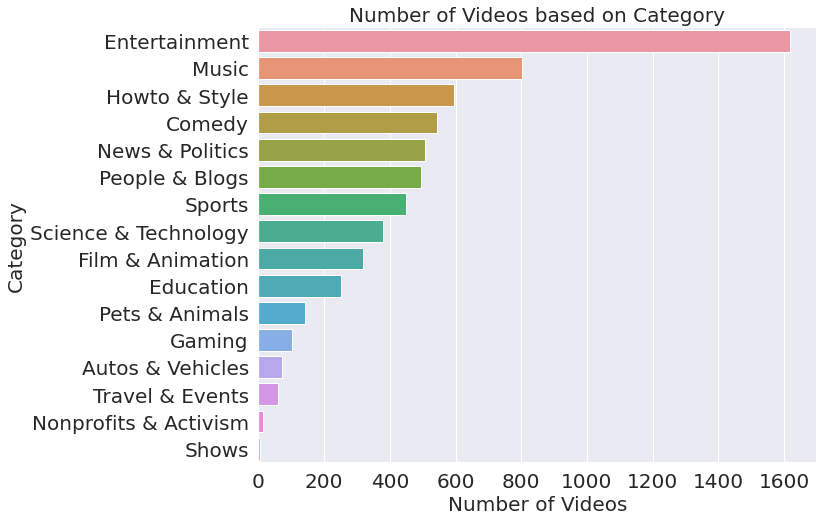

In [17]:
cat_cnt = data_clean.category.value_counts().to_frame().reset_index()
cat_cnt.rename(columns={'index':'Category', 'category':'Num_Videos'}, inplace = True)
plt.figure(figsize=(10,8))
sns.barplot(data = cat_cnt, y='Category', x = 'Num_Videos')
plt.xlabel('Number of Videos', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Number of Videos based on Category', fontsize=20)
plt.show()

In [18]:
pct_ent = round(cat_cnt[cat_cnt['Category'] == 'Entertainment'].Num_Videos/len(data_clean)*100,2)[0]
print('{}% of all videos are videos with the entertainment category'.format(pct_ent))

25.46% of all videos are videos with the entertainment category


* The category that has **the most trending videos** is **entertainment with 1617 videos**, followed by **music with 801 videos** and **style with 595 videos**.
* The entertainment category has twice as many trending videos as the music category.
* The categories that have the **least trending** videos are **shows and Nonprofits/Activism.**
* 25.46% of all videos are videos with the entertainment category

## Which channels produced most trending videos?


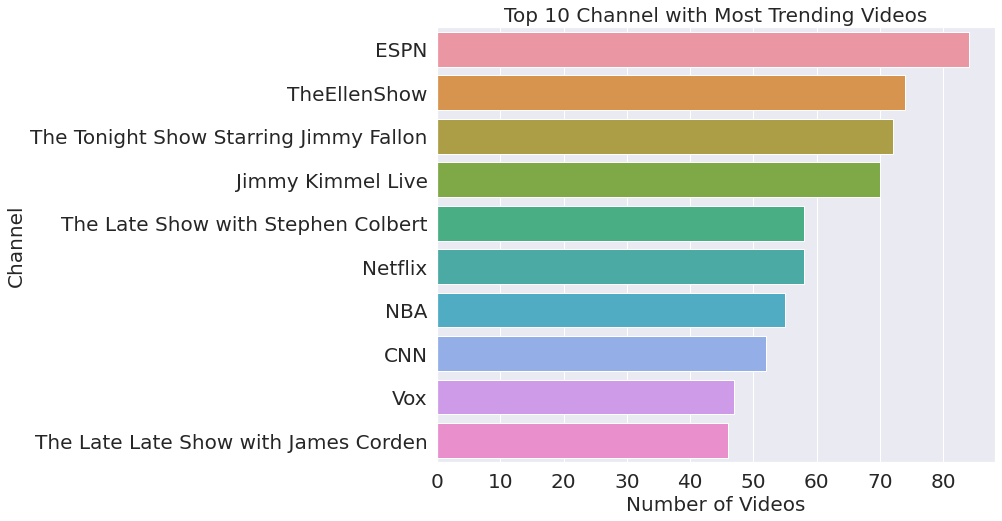

In [19]:
chn_cnt = data_clean.channel_title.value_counts().to_frame().reset_index().head(10)
chn_cnt.rename(columns={'index':'Channel', 'channel_title':'Num_Videos'}, inplace = True)
plt.figure(figsize=(10,8))
sns.barplot(data = chn_cnt, y='Channel', x = 'Num_Videos')

plt.xlabel('Number of Videos', fontsize=20)
plt.ylabel('Channel', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Top 10 Channel with Most Trending Videos', fontsize=20)
plt.show()

* based on the top 10 trending videos, **there are 6 out of 10 channels in the entertainment category**, such as TheEllenhow, The Tonight Show Starring Jimmy Fallon, Jimmi Kimmel Live, etc.
* Channel with the Most Trending Videos is **ESPN (Sports) with 84 Videos,** followed by TheEllenhow, and The Tonight Show Starring Jimmy Fallon

In [20]:
data_clean.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'id', 'category'],
      dtype='object')

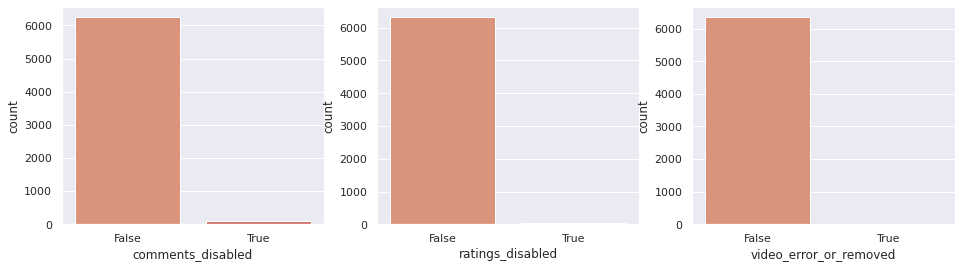

In [21]:
com_dis = data_clean.comments_disabled.value_counts().to_frame().reset_index().head(10)
com_dis.rename(columns={'index':'boole', 'channel_title':'comments_disabled'}, inplace = True)
com_dis.boole = com_dis.boole.astype('str')
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

sns.countplot(x='comments_disabled', data=data_clean, ax=ax1)
# plt.ylabel('Freq', fontsize=15)
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)
# plt.title('Comments Disabled', fontsize=15)


sns.countplot(x='ratings_disabled', data=data_clean, ax=ax2)

# plt.ylabel('Freq', fontsize=15)
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)
# plt.title('Ratings Disabled', fontsize=15)

sns.countplot(x='video_error_or_removed', data=data_clean, ax=ax3)

# plt.ylabel('Freq', fontsize=15)
# plt.yticks(fontsize=15)
# plt.xticks(fontsize=15)
# plt.title('Video Error or Removed', fontsize=15)

## Video Titles


In [22]:
# Just take data type object, and 
data_str = data.select_dtypes('object')
data_str.drop_duplicates(subset ="video_id", keep='first', inplace=True)
data_str

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


video_id                                              title  \
0      2kyS6SvSYSE                 WE WANT TO TALK ABOUT OUR MARRIAGE   
1      0mlNzVSJrT0                               Me-O Cats Commercial   
2      STI2fI7sKMo  AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...   
3      KODzih-pYlU  BLIND(folded) CAKE DECORATING CONTEST (with Mo...   
4      8mhTWqWlQzU      Wearing Online Dollar Store Makeup For A Week   
...            ...                                                ...   
40883  pwGbwYAfSmg                  5 books worth reading this summer   
40892  lM0yu7c6lQk  You're not crazy. Apple is slowing down older ...   
40903  Q1CFfU2gXHw  Apple HomePod: Everything to know before you b...   
40908  7_FJUSBFbJM  Game of Zones - Game of Zones - S5:E1: 'A Gold...   
40924  V6ElE2xs48c       Game of Zones - S5:E5: The Isle of Van Gundy   

            channel_title                                               tags  \
0            CaseyNeistat                                    SHANtell martin   
1                 Nobrand                          cute|"cats"|"thai"|"eggs"   
2      Shawn Johnson East  shawn johnson|"andrew east"|"shawn east"|"shaw...   
3            Grace Helbig  itsgrace|"funny"|"comedy"|"vlog"|"grace"|"helb...   
4          Safiya Nygaard  wearing online dollar store makeup for a week|...   
...                   ...                                                ...   
40883          Bill Gates                                       Bill|"Gates"   
40892                CNET  Apple|"iPhone Slowdown"|"Apple Battery"|"Cultu...   
40903                CNET  Apple|"Homepod"|"smart home"|"Google Home"|"Am...   
40908     Bleacher Report  bleacher report|"br"|"nba"|"game of zones"|"go...   
40924     Bleacher Report  bleacher report|"br"|"nba"|"Stan Van Gundy"|"J...   

                                             description  \
0      SHANTELL'S CHANNEL - https://www.youtube.com/s...   
1      Kittens come out of the eggs in a Thai commerc...   
2      Subscribe for weekly videos ▶ http://bit.ly/sj...   
3      Molly is an god damn amazing human and she cha...   
4      I found this online dollar store called ShopMi...   
...                                                  ...   
40883  If you’re looking for something to read over t...   
40892  Apple comes clean after overwhelming evidence ...   
40903  We'll break down all the new Apple HomePod det...   
40908  In the season 5 premiere of Game of Zones, the...   
40924  On an island full of Van Gundys, Stan gets tal...   

                    category  
0             People & Blogs  
1             People & Blogs  
2             People & Blogs  
3             People & Blogs  
4             People & Blogs  
...                      ...  
40883  Nonprofits & Activism  
40892                  Shows  
40903                  Shows  
40908                  Shows  
40924                  Shows  

[6351 rows x 6 columns]

In [23]:
## Data Processing

df_title = pd.DataFrame()

# Expanding Contractions
df_title['title_cleaned'] = data_str['title'].apply(lambda x: [contractions.fix(word) for word in x.split()])
df_title['title_cleaned'] = [' '.join(map(str, l)) for l in df_title['title_cleaned']]

# Converting all Characters to Lowercase
df_title['title_cleaned'] = df_title['title_cleaned'].str.lower()

# Remove punctuation
df_title['title_cleaned'] = df_title['title_cleaned'].str.replace(r'[^\w\s]+', '')

# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df_title['title_cleaned'] = df_title['title_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenization
nltk.download('punkt')
df_title["title_tokenized"] = df_title["title_cleaned"].apply(word_tokenize)

df_title.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


title_cleaned  \
0                                 want talk marriage   
1                                meo cats commercial   
2  affairs ex boyfriends 18million net worth goog...   
3  blindfolded cake decorating contest molly burk...   
4            wearing online dollar store makeup week   

                                     title_tokenized  
0                             [want, talk, marriage]  
1                            [meo, cats, commercial]  
2  [affairs, ex, boyfriends, 18million, net, wort...  
3  [blindfolded, cake, decorating, contest, molly...  
4     [wearing, online, dollar, store, makeup, week]

In [24]:
# collect data into one list
title_words = []
for wordlist in df_title['title_tokenized']:
    title_words += wordlist
print(title_words)

['want', 'talk', 'marriage', 'meo', 'cats', 'commercial', 'affairs', 'ex', 'boyfriends', '18million', 'net', 'worth', 'google', 'us', 'shawn', 'andrew', 'blindfolded', 'cake', 'decorating', 'contest', 'molly', 'burke', 'grace', 'helbig', 'wearing', 'online', 'dollar', 'store', 'makeup', 'week', 'mark', 'ruffalo', 'reads', 'hilarious', 'thirst', 'tweets', 'idiots', 'guide', 'japanese', 'squat', 'toilets', 'russian', 'bots', 'trolls', 'november', '8', '2017', 'act', '2', 'full', 'frontal', 'tbs', 'ultimate', 'red', 'lip', 'look', 'nicole', 'guerriero', 'could', 'anastasia', 'become', 'disney', 'princess', 'mdna', 'skin', 'express', 'picked', 'girlfriends', 'outfit', 'blindfolded', 'love', 'price', 'right', 'wooo', 'kevin', 'see', 'around', 'official', 'audio', 'boyfriend', 'makeup', 'madelaine', 'petsch', 'apple', 'clips', 'sample', 'kids', 'describe', 'america', 'koji', 'illustrator', 'huge', 'beauty', 'favourites', 'autumn', 'loves', 'bill', 'gates', 'bought', 'land', 'arizona', 'build

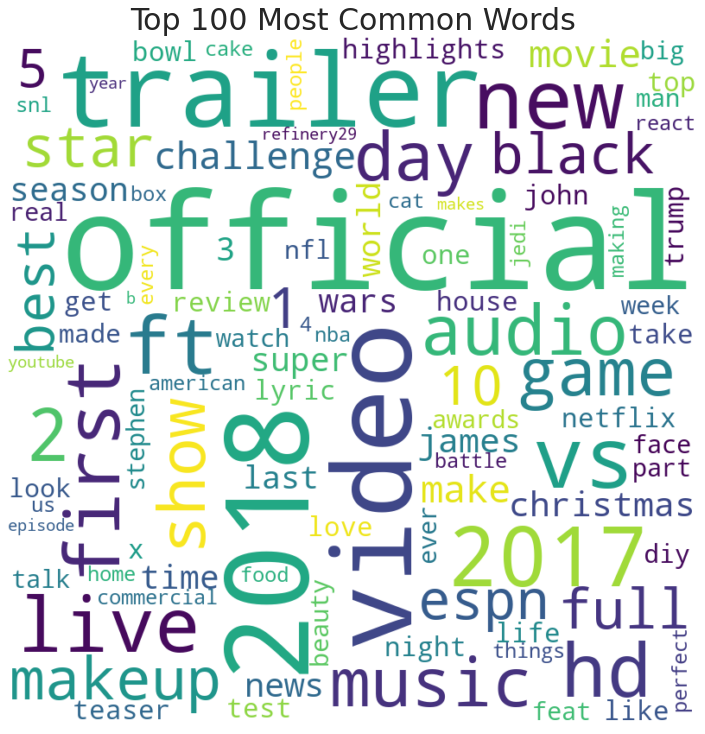

In [25]:
# Word Cloud in titles
mostcommon = FreqDist(title_words).most_common(100)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=30)
plt.tight_layout(pad=0)
plt.show()

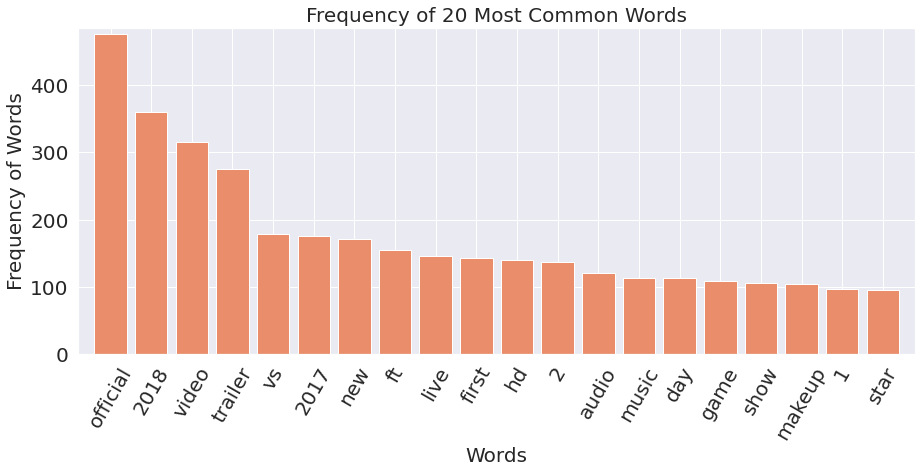

In [26]:
mostcommon_small = FreqDist(title_words).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 20 Most Common Words', fontsize=20)
plt.show()

* **Based on chart and word cloud** we can see that the **word that appears the most** is **"official"** followed by **"2018"** and **"video"**. this is because 65% of videos uploaded in 2018

In [27]:
# Bigram Data
tokenizer = RegexpTokenizer(r"[\w']+")
ng2 = [ngrams(tokenizer.tokenize(t.lower()), n=2) for t in df_title['title_cleaned']]

ng2 = [x for y in ng2 for x in y]
ng2 = [x + '-' + y for x,y in ng2]

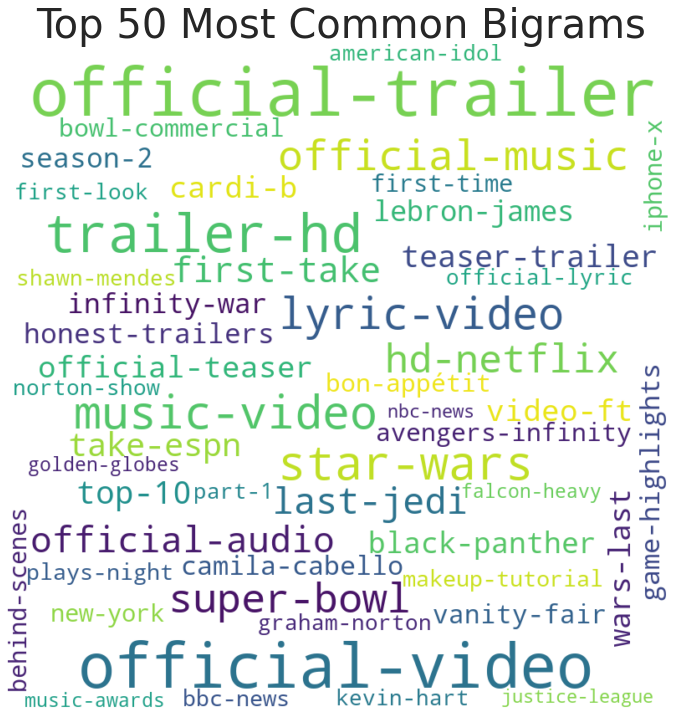

In [28]:
mostcommon = FreqDist(ng2).most_common(50)
wordcloud = WordCloud(width=800, height=800, background_color='white', normalize_plurals=False, regexp=r".+").generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Bigrams', fontsize=40)
plt.tight_layout(pad=0)
plt.show()

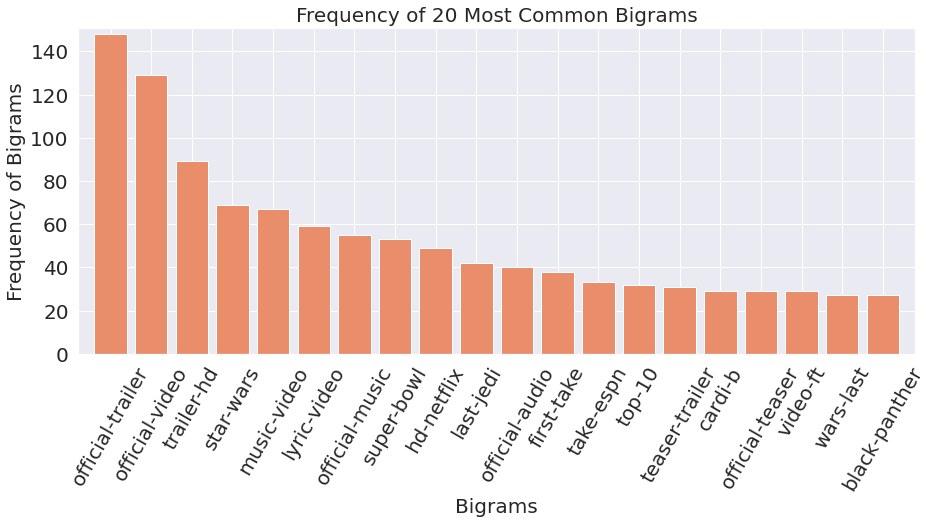

In [29]:
mostcommon_small = FreqDist(ng2).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Bigrams', fontsize=20)
plt.ylabel('Frequency of Bigrams', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 20 Most Common Bigrams', fontsize=20)
plt.show()

In [30]:
tokenizer = RegexpTokenizer(r"[\w']+")
ng3 = [ngrams(tokenizer.tokenize(t.lower()), n=3) for t in df_title['title_cleaned']]
ng3 = [x for y in ng3 for x in y]
ng3 = [x + '-' + y + '-' + z for x,y,z in ng3]

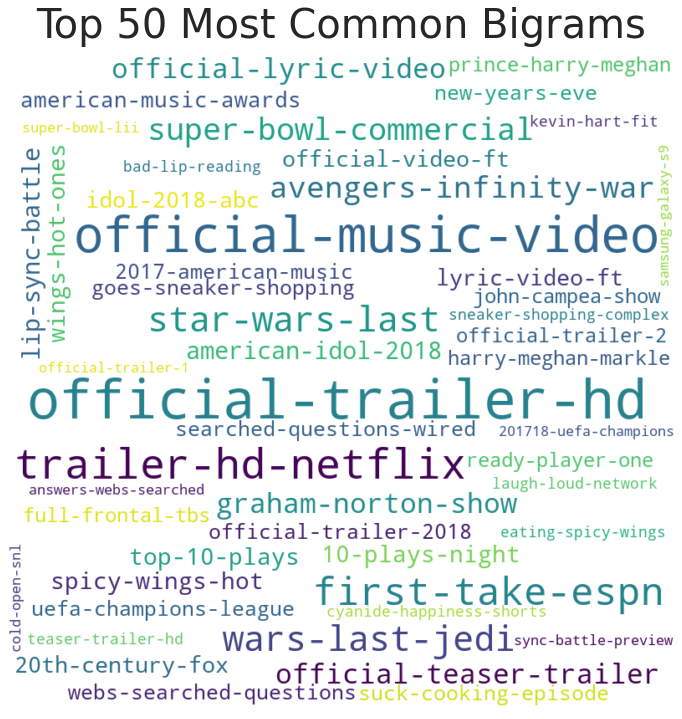

In [31]:
mostcommon = FreqDist(ng3).most_common(50)
wordcloud = WordCloud(width=800, height=800, background_color='white', normalize_plurals=False, regexp=r".+").generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 50 Most Common Bigrams', fontsize=40)
plt.tight_layout(pad=0)
plt.show()

In [32]:
mostcommon_small = FreqDist(ng3).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,5))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Trigrams', fontsize=20)
plt.ylabel('Frequency of Trigrams', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 20 Most Common Trigrams', fontsize=20)
plt.show()

* Based on Bigrams and Trigrams, we can conclude that the most combinations of words focus on **film trailers and music videos**, for example, the films **Star Wars: The Last Jedi and Avengers: Infinity Wars**.

## Video Description

In [33]:
df_desc = pd.DataFrame()

# Expanding Contractions
df_desc['desc_cleaned'] = data_str['description'].dropna().apply(lambda x: [contractions.fix(word) for word in x.split()])
df_desc['desc_cleaned'] = [' '.join(map(str, l)) for l in df_desc['desc_cleaned']]

# Converting all Characters to Lowercase
df_desc['desc_cleaned'] = df_desc['desc_cleaned'].str.lower()

# replace . and / from the link in the description
df_desc['desc_cleaned'] = df_desc['desc_cleaned'].str.replace('.', ' ')
df_desc['desc_cleaned'] = df_desc['desc_cleaned'].str.replace('/', ' ')

# Remove punctuation
df_desc['desc_cleaned'] = df_desc['desc_cleaned'].str.replace(r'[^\w\s]+', '')

# Remove stopwords
df_desc['desc_cleaned'] = df_desc['desc_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenization
df_desc["desc_tokenized"] = df_desc["desc_cleaned"].apply(word_tokenize)

df_desc.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  from ipykernel import kernelapp as app


desc_cleaned  \
0  shantells channel https www youtube com shante...   
1  kittens come eggs thai commercialnnreuploaded ...   
2  subscribe weekly videos http bit ly sjofficoak...   
3  molly god damn amazing human challenged blind ...   
4  found online dollar store called shopmissa sel...   

                                      desc_tokenized  
0  [shantells, channel, https, www, youtube, com,...  
1  [kittens, come, eggs, thai, commercialnnreuplo...  
2  [subscribe, weekly, videos, http, bit, ly, sjo...  
3  [molly, god, damn, amazing, human, challenged,...  
4  [found, online, dollar, store, called, shopmis...

In [34]:
desc_words = []
for wordlist in df_desc['desc_tokenized']:
    desc_words += wordlist
# print(desc_words)

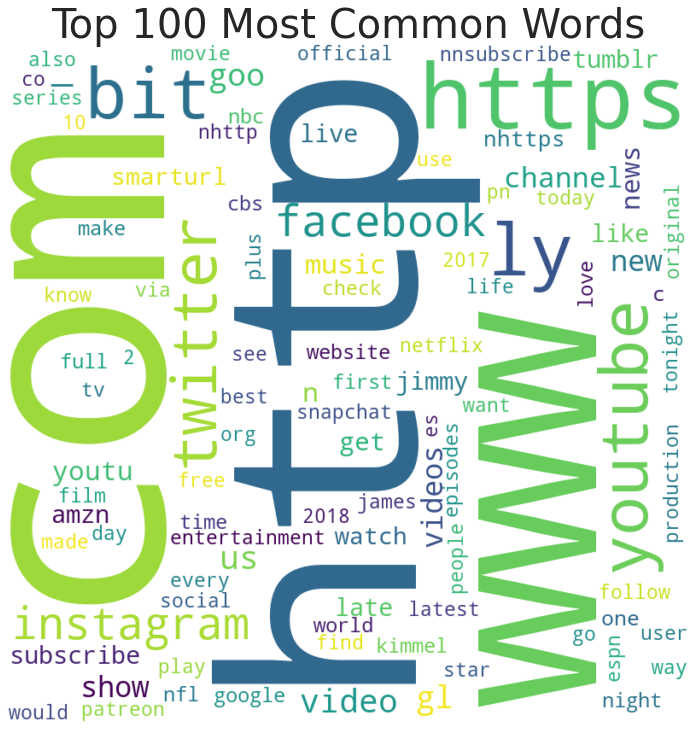

In [35]:
# Word Cloud in titles
mostcommon = FreqDist(desc_words).most_common(100)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=40)
plt.tight_layout(pad=0)
plt.show()

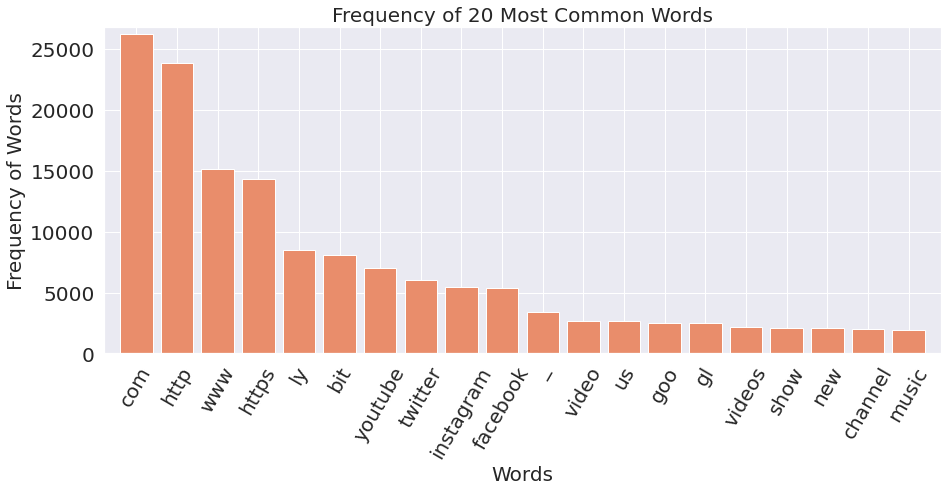

In [36]:
mostcommon_small = FreqDist(desc_words).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 20 Most Common Words', fontsize=20)
plt.show()

In [37]:
tokenizer = RegexpTokenizer(r"[\w']+")
ng2 = [ngrams(tokenizer.tokenize(t.lower()), n=2) for t in df_desc['desc_cleaned']]

ng2 = [x for y in ng2 for x in y]
ng2 = [x + '-' + y for x,y in ng2]

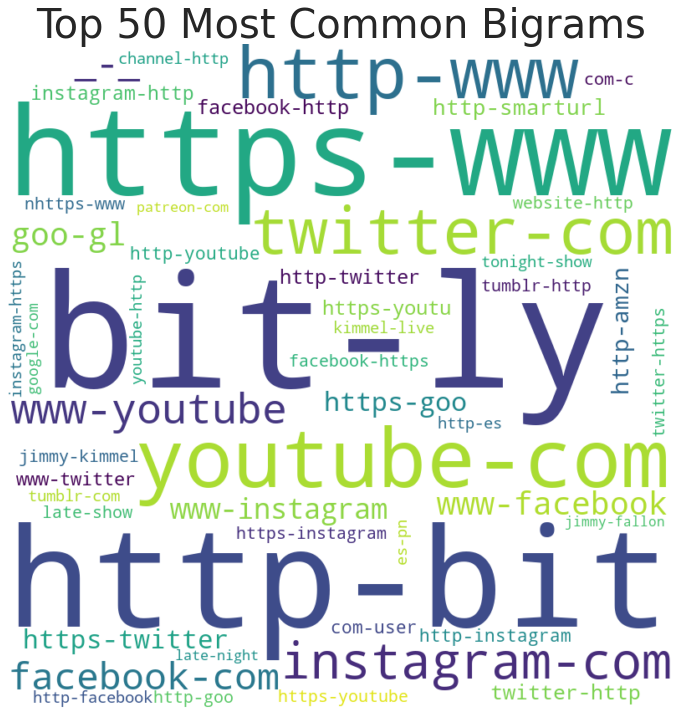

In [38]:
mostcommon = FreqDist(ng2).most_common(50)
wordcloud = WordCloud(width=800, height=800, background_color='white', normalize_plurals=False, regexp=r".+").generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Bigrams', fontsize=40)
plt.tight_layout(pad=0)
plt.show()

In [39]:
mostcommon_small = FreqDist(ng2).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Bigrams', fontsize=20)
plt.ylabel('Frequency of Bigrams', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 20 Most Common Bigrams', fontsize=20)
plt.show()

In [40]:
tokenizer = RegexpTokenizer(r"[\w']+")
ng3 = [ngrams(tokenizer.tokenize(t.lower()), n=3) for t in df_desc['desc_cleaned']]
ng3 = [x for y in ng3 for x in y]
ng3 = [x + '-' + y + '-' + z for x,y,z in ng3]

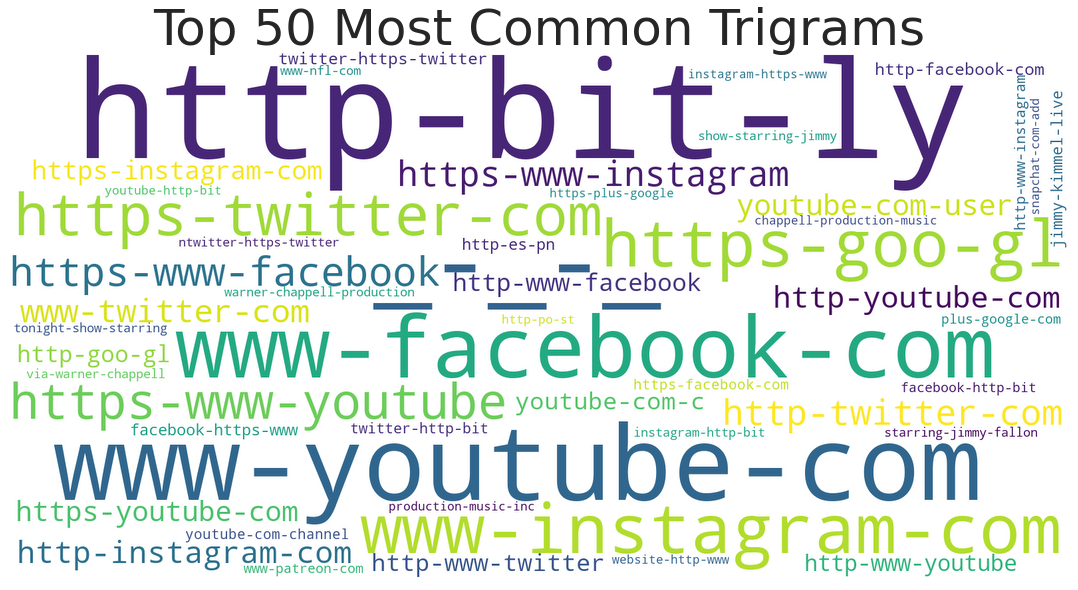

In [41]:
mostcommon = FreqDist(ng3).most_common(50)
wordcloud = WordCloud(width=1600, height=800, background_color='white', normalize_plurals=False, regexp=r".+").generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(20,8), facecolor='white')
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
plt.title('Top 50 Most Common Trigrams', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

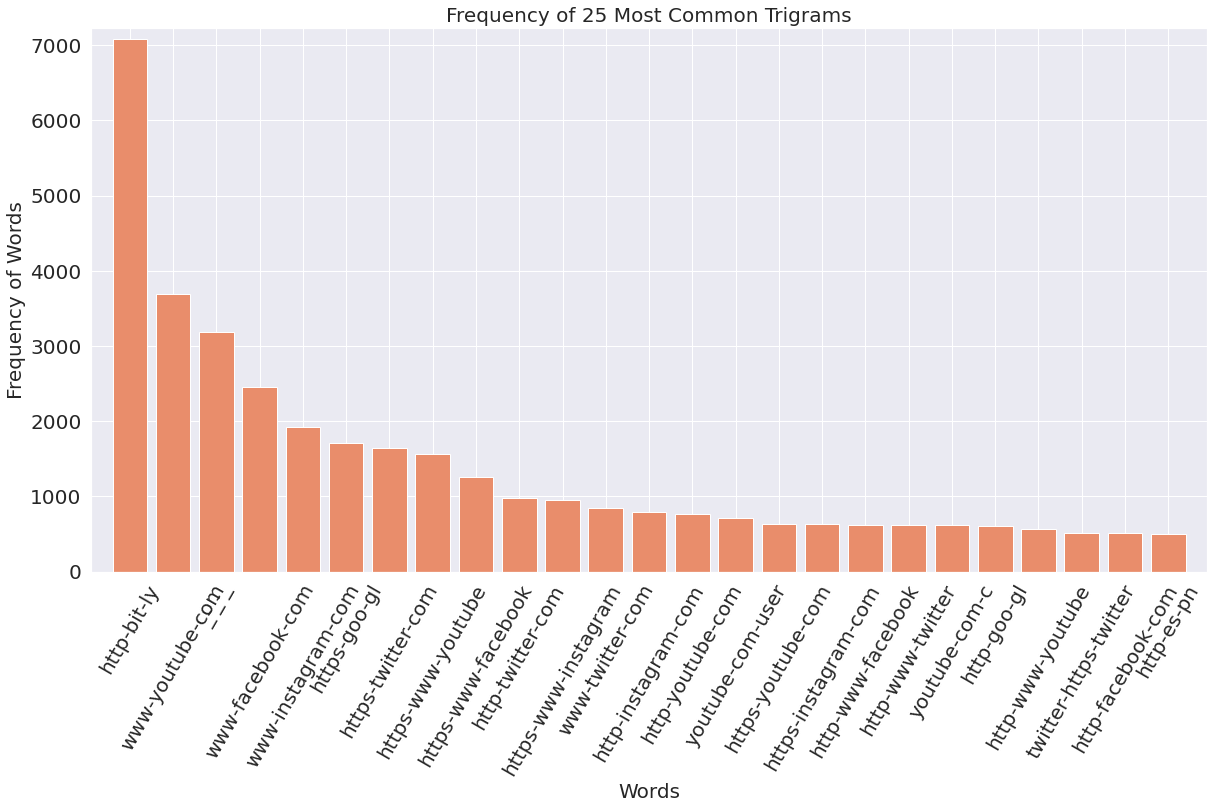

In [42]:
mostcommon_small = FreqDist(ng3).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(20,10))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 25 Most Common Trigrams', fontsize=20)
plt.show()

* In the video description, most users include their **social media links such as Google, Facebook, Instagram, and Twitter or other things that require links**, for example download links and product links. Another word that is pretty much listed in the description is a **request to subscribe to the channel**

## Video Tags

In [43]:
df_tags = pd.DataFrame()

# Expanding Contractions
df_tags['tags_cleaned'] = data_str['tags'].dropna().apply(lambda x: [contractions.fix(word) for word in x.split()])
df_tags['tags_cleaned'] = [' '.join(map(str, l)) for l in df_tags['tags_cleaned']]

# Converting all Characters to Lowercase
df_tags['tags_cleaned'] = df_tags['tags_cleaned'].str.lower()

# Remove punctuation
# df_tags['desc_cleaned'] = df_tags['desc_cleaned'].str.replace('.', ' ')
df_tags['tags_cleaned'] = df_tags['tags_cleaned'].str.replace('|', ' ')
df_tags['tags_cleaned'] = df_tags['tags_cleaned'].str.replace(r'[^\w\s]+', '')

# Remove stopwords
df_tags['tags_cleaned'] = df_tags['tags_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# Tokenization
df_tags["tags_tokenized"] = df_tags["tags_cleaned"].apply(word_tokenize)

df_tags.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  del sys.path[0]


tags_cleaned  \
0                                    shantell martin   
1                                cute cats thai eggs   
2  shawn johnson andrew east shawn east shawn and...   
3  itsgrace funny comedy vlog grace helbig graceh...   
4  wearing online dollar store makeup week online...   

                                      tags_tokenized  
0                                 [shantell, martin]  
1                           [cute, cats, thai, eggs]  
2  [shawn, johnson, andrew, east, shawn, east, sh...  
3  [itsgrace, funny, comedy, vlog, grace, helbig,...  
4  [wearing, online, dollar, store, makeup, week,...

In [44]:
tags_words = []
for wordlist in df_tags['tags_tokenized']:
    tags_words += wordlist
# print(tags_words)

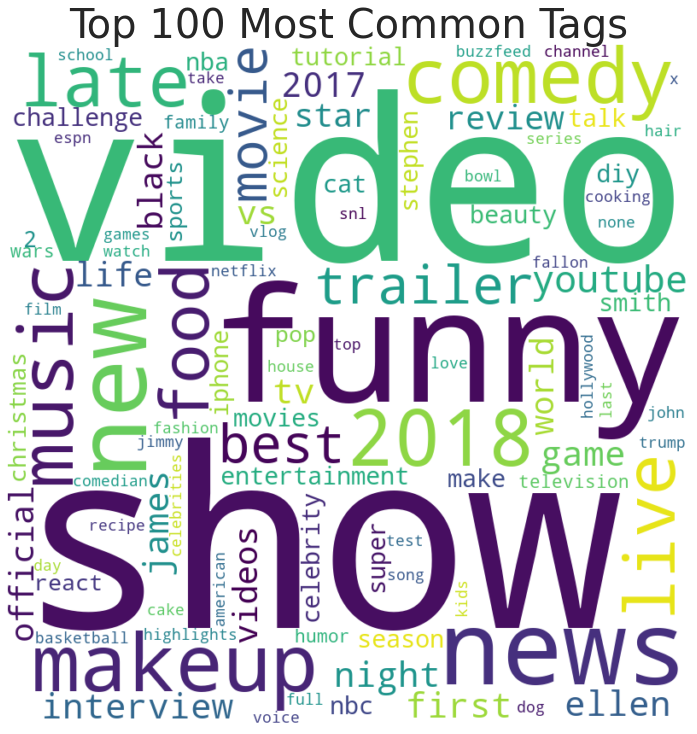

In [45]:
# Word Cloud in titles
mostcommon = FreqDist(tags_words).most_common(100)
wordcloud = WordCloud(width=800, height=800, background_color='white').generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Tags', fontsize=40)
plt.tight_layout(pad=0)
plt.show()

In [46]:
mostcommon_small = FreqDist(tags_words).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Tags', fontsize=20)
plt.ylabel('Frequency of Tags', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 20 Most Common Tags', fontsize=20)
plt.show()

In [47]:
tokenizer = RegexpTokenizer(r"[\w']+")
ng2 = [ngrams(tokenizer.tokenize(t.lower()), n=2) for t in df_tags['tags_cleaned']]

ng2 = [x for y in ng2 for x in y]
ng2 = [x + '-' + y for x,y in ng2]

In [48]:
mostcommon = FreqDist(ng2).most_common(50)
wordcloud = WordCloud(width=800, height=800, background_color='white', normalize_plurals=False, regexp=r".+").generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(10,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Most Common Bigrams', fontsize=40)
plt.tight_layout(pad=0)
plt.show()

In [49]:
mostcommon_small = FreqDist(ng2).most_common(20)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(15,6))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Bigrams', fontsize=20)
plt.ylabel('Frequency of Bigrams', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 25 Most Common Bigrams', fontsize=20)
plt.show()

In [50]:
tokenizer = RegexpTokenizer(r"[\w']+")
ng3 = [ngrams(tokenizer.tokenize(t.lower()), n=3) for t in df_tags['tags_cleaned']]
ng3 = [x for y in ng3 for x in y]
ng3 = [x + '-' + y + '-' + z for x,y,z in ng3]

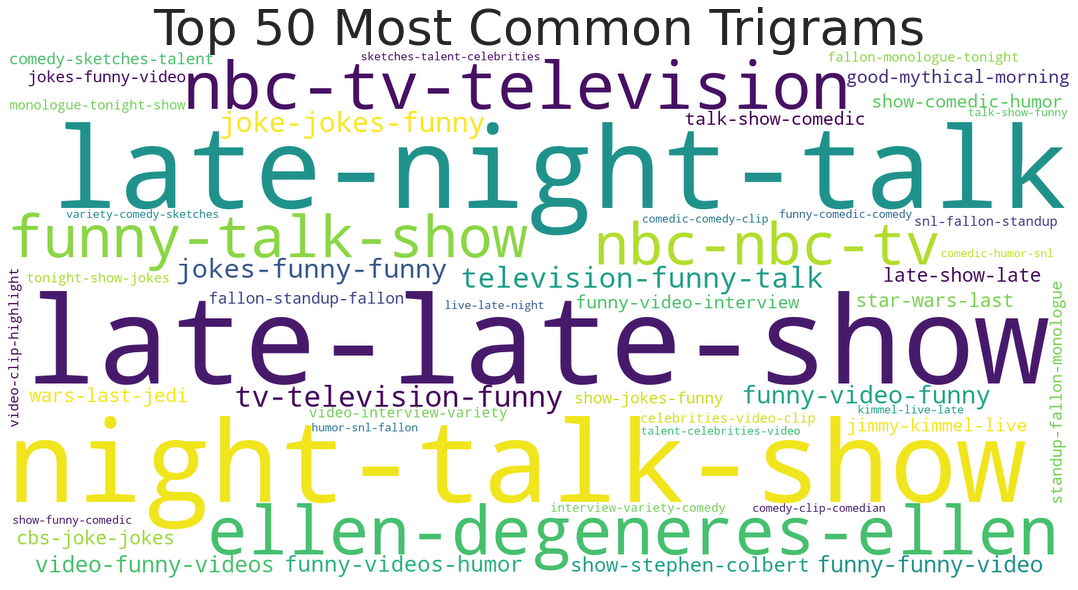

In [51]:
mostcommon = FreqDist(ng3).most_common(50)
wordcloud = WordCloud(width=1600, height=800, background_color='white', normalize_plurals=False, regexp=r".+").generate_from_frequencies(dict(mostcommon))
fig = plt.figure(figsize=(20,8), facecolor='white')
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis('off')
plt.title('Top 50 Most Common Trigrams', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

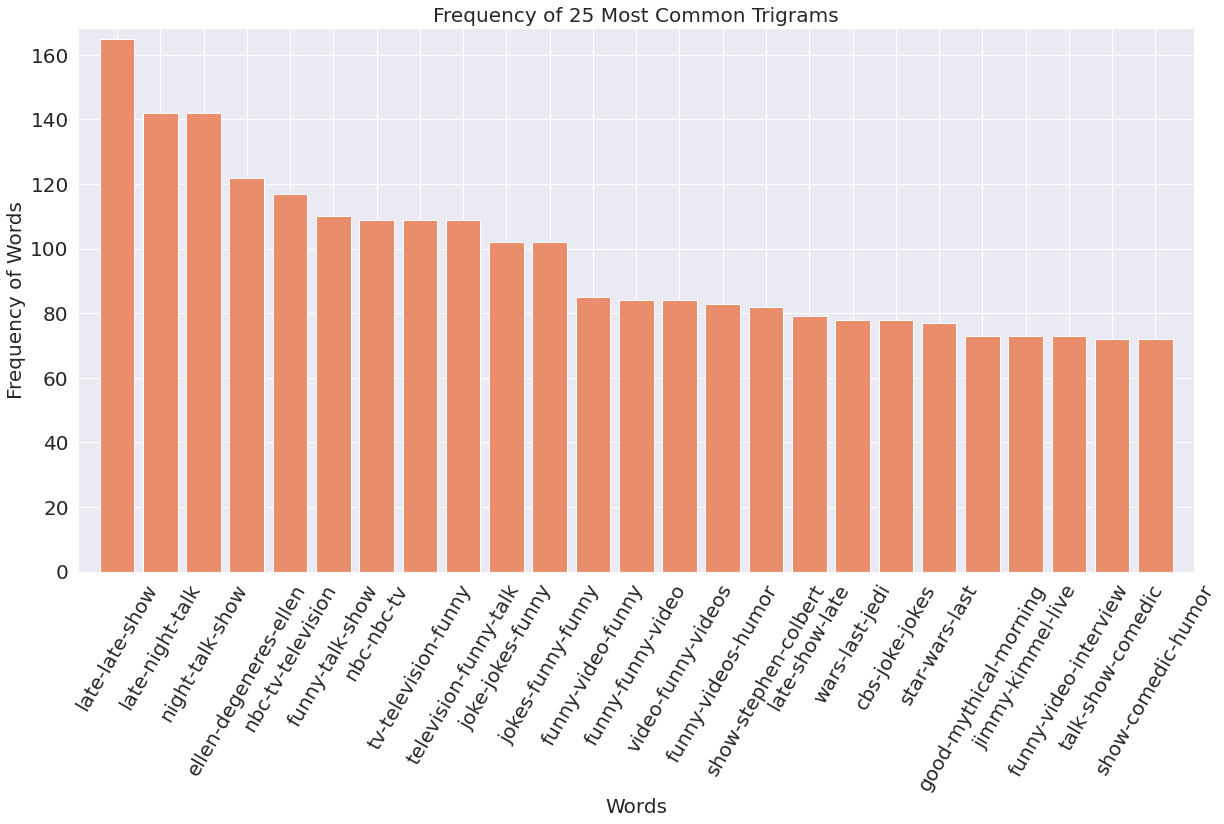

In [52]:
mostcommon_small = FreqDist(ng3).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(20,10))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Frequency of 25 Most Common Trigrams', fontsize=20)
plt.show()

## Video Comments

In [53]:
data_clean['comment_count'].describe()

count    6.351000e+03
mean     6.450380e+03
std      3.382373e+04
min      0.000000e+00
25%      3.720000e+02
50%      1.266000e+03
75%      4.061500e+03
max      1.361580e+06
Name: comment_count, dtype: float64

### Video Comments Distribution

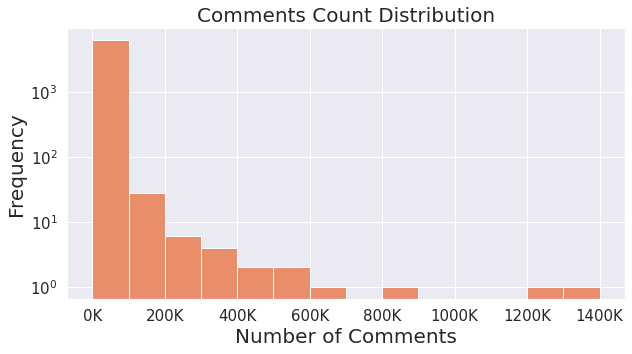

In [54]:
ax = data_clean['comment_count'].plot(kind='hist', bins=np.arange(0, 1.5e6, 1e5), figsize=(10,5), logy=True)

formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}K'.format(x/1e3))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of Comments', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Comments Count Distribution', fontsize=20)
plt.show()

### Top 5 Trending Videos Based on Number of Comments

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

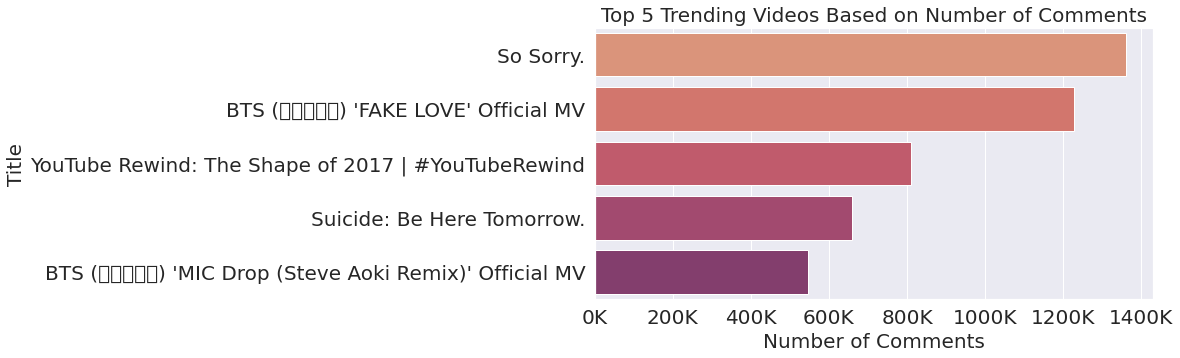

In [55]:
data_clean.sort_values('comment_count', ascending = False)
plt.figure(figsize=(10,5))
ax = sns.barplot(data = data_clean.sort_values('comment_count', ascending = False).head(5),
            x = 'comment_count',
            y = 'title')
formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}K'.format(x/1e3))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of Comments', fontsize=20)
plt.ylabel('Title', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Top 5 Trending Videos Based on Number of Comments', fontsize=20)
plt.show()

In [56]:
data_clean[['title', 'channel_title', 'category', 'publish_time',  'comment_count']].sort_values('comment_count', ascending = False).head(5)

title      channel_title  \
5912                                           So Sorry.   Logan Paul Vlogs   
31839                BTS (방탄소년단) 'FAKE LOVE' Official MV            ibighit   
4703   YouTube Rewind: The Shape of 2017 | #YouTubeRe...  YouTube Spotlight   
40865                         Suicide: Be Here Tomorrow.   Logan Paul Vlogs   
26673  BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...            ibighit   

                    category              publish_time  comment_count  
5912           Entertainment 2018-01-02 16:42:21+00:00        1361580  
31839                  Music 2018-05-18 09:00:02+00:00        1228655  
4703           Entertainment 2017-12-06 17:58:51+00:00         810698  
40865  Nonprofits & Activism 2018-01-24 18:30:01+00:00         658130  
26673                  Music 2017-11-24 09:00:02+00:00         546100

### Comments Distribution by Category

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

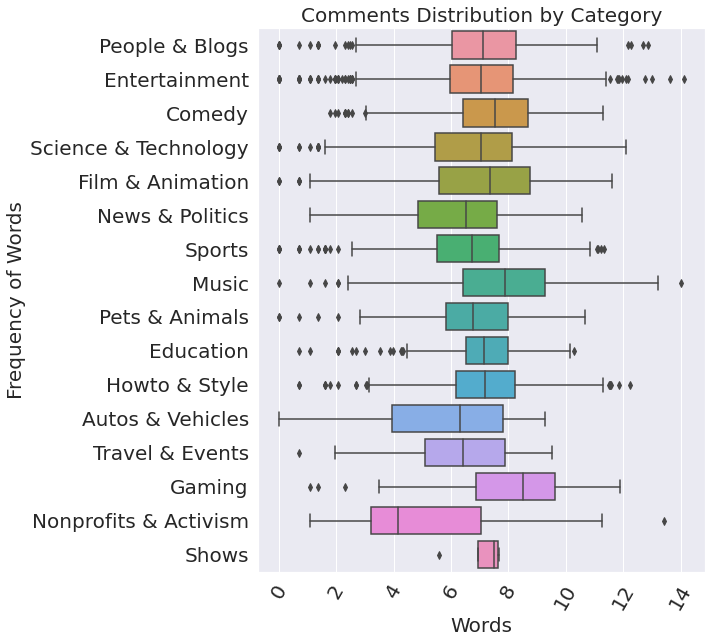

In [57]:
data_clean['likes_log'] = np.log(data_clean['likes'] + 1)
data_clean['views_log'] = np.log(data_clean['views'] + 1)
data_clean['dislikes_log'] = np.log(data_clean['dislikes'] + 1)
data_clean['comment_log'] = np.log(data_clean['comment_count'])

plt.figure(figsize=(8,10))
ax = sns.boxplot(y="category", x="comment_log", data=data_clean)

plt.xlabel('Words', fontsize=20)
plt.ylabel('Frequency of Words', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Comments Distribution by Category', fontsize=20)
plt.show()

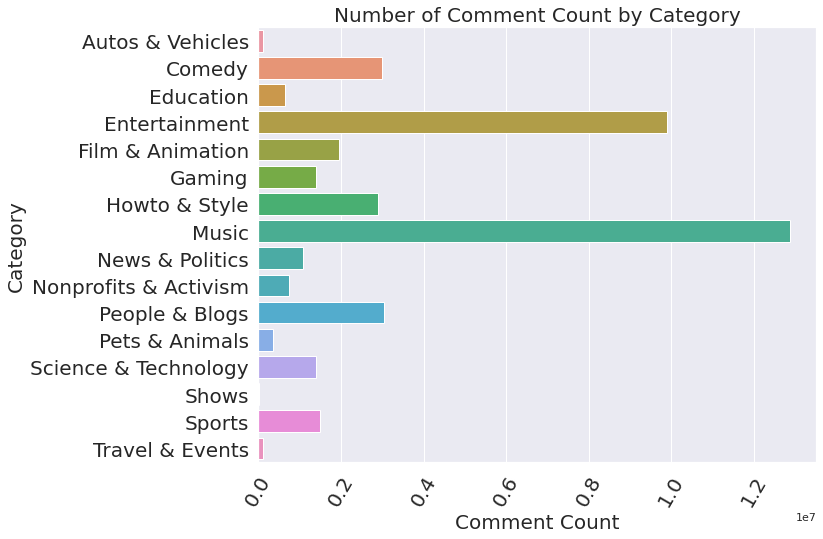

In [58]:
plt.figure(figsize=(10,8))
ax = sns.barplot(data = data_clean.groupby('category').agg({'comment_count':'sum'}).reset_index(), y='category', x='comment_count')

plt.xlabel('Comment Count', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Number of Comment Count by Category', fontsize=20)
plt.show()

In [59]:
data_clean[data_clean['comment_count'] < 100000].shape[0] / data_clean.shape[0] * 100

99.2757046134467

In [60]:
data_clean['comment_count'].quantile(q=0.9)

11775.0

* From the distribution we can see that the **majority of trending videos have less than 100k comments.** **99.27%** of trending videos have less than 100k comments and **90%** of trending videos have less than 11,775 comments.

* We can notice that **only two videos that have more than 1 million comments**, BTS 'Fake Love' Music Video and So Sorry from Logan Paul.

* **Gaming is the category with the highest average number of comments** followed by Music, Comedy, and Shows.

## Video Likes

In [61]:
data_clean['likes'].describe()

count    6.351000e+03
mean     5.557323e+04
std      1.938312e+05
min      0.000000e+00
25%      2.771000e+03
50%      1.190600e+04
75%      3.842850e+04
max      5.613827e+06
Name: likes, dtype: float64

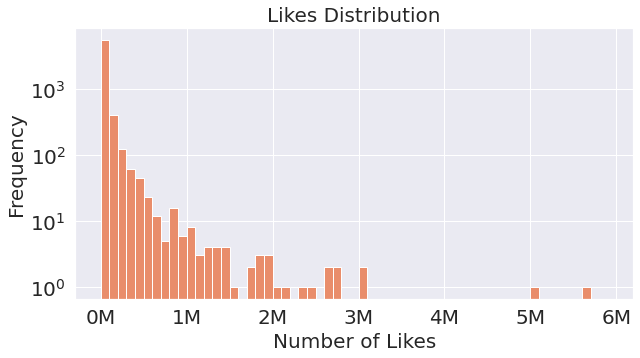

In [62]:
ax = data_clean['likes'].plot(kind='hist', bins=np.arange(0, 6e6, 1e5), figsize=(10,5), logy=True)

formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}M'.format(x/1e6))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of Likes', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Likes Distribution', fontsize=20)
plt.show()

### Top 5 Trending Videos Based on Number of Likes

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

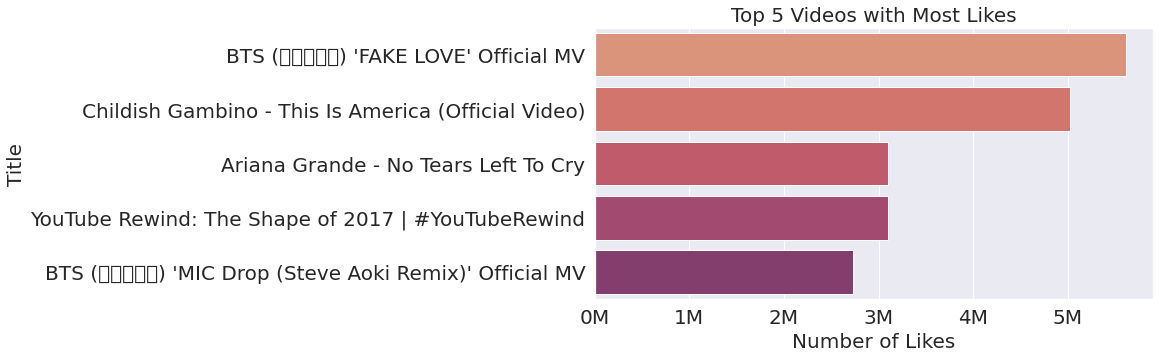

In [63]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = data_clean.sort_values('likes', ascending = False).head(5),
            x = 'likes',
            y = 'title')
formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}M'.format(x/1e6))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of Likes', fontsize=20)
plt.ylabel('Title', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Top 5 Videos with Most Likes', fontsize=20)
plt.show()

In [64]:
data_clean[['title', 'channel_title', 'category', 'publish_time',  'likes']].sort_values('likes', ascending = False).head(5)

title        channel_title  \
31839                BTS (방탄소년단) 'FAKE LOVE' Official MV              ibighit   
31902  Childish Gambino - This Is America (Official V...  ChildishGambinoVEVO   
31170               Ariana Grande - No Tears Left To Cry     ArianaGrandeVevo   
4703   YouTube Rewind: The Shape of 2017 | #YouTubeRe...    YouTube Spotlight   
26673  BTS (방탄소년단) 'MIC Drop (Steve Aoki Remix)' Offi...              ibighit   

            category              publish_time    likes  
31839          Music 2018-05-18 09:00:02+00:00  5613827  
31902          Music 2018-05-06 04:00:07+00:00  5023450  
31170          Music 2018-04-20 04:00:03+00:00  3094021  
4703   Entertainment 2017-12-06 17:58:51+00:00  3093544  
26673          Music 2017-11-24 09:00:02+00:00  2729292

### Likes Distribution by Category

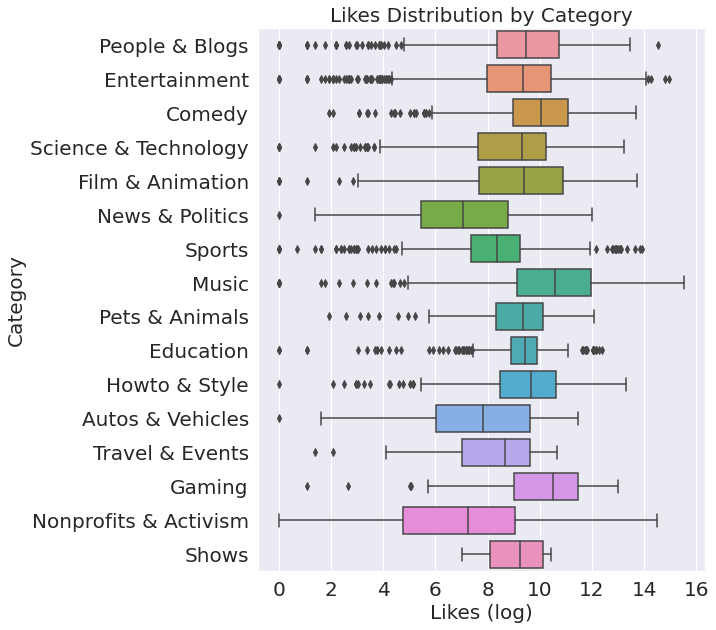

In [65]:
plt.figure(figsize=(8,10))
ax = sns.boxplot(y="category", x="likes_log", data=data_clean)

plt.xlabel('Likes (log)', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Likes Distribution by Category', fontsize=20)
plt.show()

In [66]:
data_clean[data_clean['likes'] < 100000].shape[0] / data_clean.shape[0] * 100

88.33254605573926

In [67]:
data_clean['likes'].quantile(q=0.9)

117929.0

* **98.33%** of trending videos have less than 500k likes

* Videos with **largest number of likes is BTS 'Fake Love' Music Video followed by Childish Gambino 'This Is America' Music Video.**

* **Music and Gaming is the category with the highest average number of likes** 

## Video Dislikes

In [68]:
data_clean['dislikes'].describe()

count    6.351000e+03
mean     3.067025e+03
std      3.198850e+04
min      0.000000e+00
25%      1.270000e+02
50%      4.440000e+02
75%      1.507000e+03
max      1.674420e+06
Name: dislikes, dtype: float64

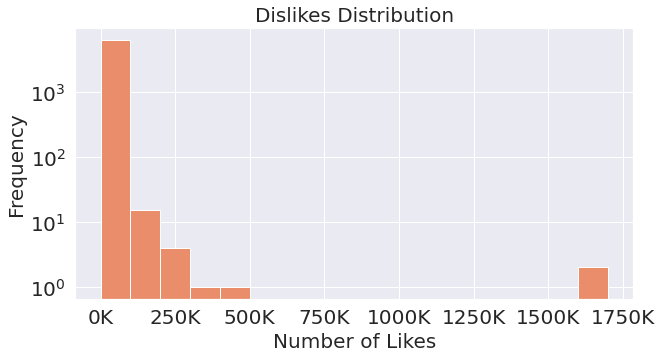

In [69]:
ax = data_clean['dislikes'].plot(kind='hist', bins=np.arange(0, 1.8e6, 1e5), figsize=(10,5), logy=True)

formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}K'.format(x/1e3))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of Likes', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Dislikes Distribution', fontsize=20)
plt.show()

### Top 5 Trending Videos Based on Number of Dislikes

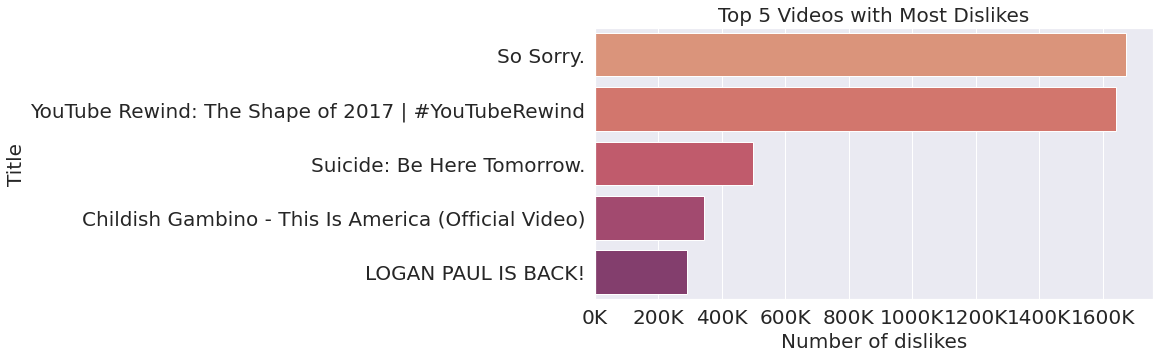

In [70]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = data_clean.sort_values('dislikes', ascending = False).head(5),
            x = 'dislikes',
            y = 'title')
formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}K'.format(x/1e3))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of dislikes', fontsize=20)
plt.ylabel('Title', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Top 5 Videos with Most Dislikes', fontsize=20)
plt.show()

In [71]:
data_clean[['title', 'channel_title', 'category', 'publish_time', 'dislikes']].sort_values('dislikes', ascending = False).head(5)

title        channel_title  \
5912                                           So Sorry.     Logan Paul Vlogs   
4703   YouTube Rewind: The Shape of 2017 | #YouTubeRe...    YouTube Spotlight   
40865                         Suicide: Be Here Tomorrow.     Logan Paul Vlogs   
31902  Childish Gambino - This Is America (Official V...  ChildishGambinoVEVO   
7238                                 LOGAN PAUL IS BACK!     Logan Paul Vlogs   

                    category              publish_time  dislikes  
5912           Entertainment 2018-01-02 16:42:21+00:00   1674420  
4703           Entertainment 2017-12-06 17:58:51+00:00   1643059  
40865  Nonprofits & Activism 2018-01-24 18:30:01+00:00    497847  
31902                  Music 2018-05-06 04:00:07+00:00    343541  
7238           Entertainment 2018-02-04 22:02:27+00:00    291900

### Dislikes Distribution by Category

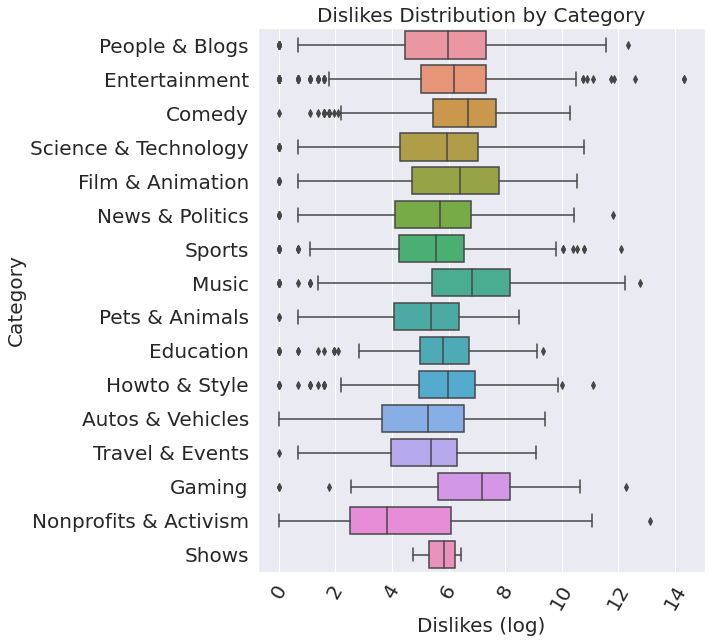

In [72]:
plt.figure(figsize=(8,10))
ax = sns.boxplot(y="category", x="dislikes_log", data=data_clean)

plt.xlabel('Dislikes (log)', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Dislikes Distribution by Category', fontsize=20)
plt.show()

In [73]:
data_clean[data_clean['dislikes'] < 10000].shape[0] / data_clean.shape[0] * 100

95.6857187844434

In [74]:
data_clean['dislikes'].quantile(q=0.9)

4514.0

* **95.68%** of trending videos have less than 10k dislikes

* Videos with **largest number of likes is So Sorry from Logan Paul followed by Youtube Rewind 2017.**

## Video Views

In [75]:
data_clean['views'].describe()

count    6.351000e+03
mean     1.962023e+06
std      7.060074e+06
min      5.590000e+02
25%      1.589615e+05
50%      5.181070e+05
75%      1.473582e+06
max      2.252119e+08
Name: views, dtype: float64

In [76]:
ax = data_clean['views'].plot(kind='hist', bins=np.arange(0, 2.3e8, 1e7), figsize=(10,5), logy=True)

formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}M'.format(x/1e6))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of Views', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Views Distribution', fontsize=20)
plt.show()

### Top 5 Trending Videos Based on Number of Views

In [77]:
plt.figure(figsize=(10,5))
ax = sns.barplot(data = data_clean.sort_values('views', ascending = False).head(5),
            x = 'views',
            y = 'title')
formatter = ticker.FuncFormatter(func=lambda x,y: '{:.0f}M'.format(x/1e6))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
plt.xlabel('Number of Views', fontsize=20)
plt.ylabel('Title', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Top 5 Videos with Most Views', fontsize=20)
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53444 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49548 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45800 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_

In [78]:
data_clean[['title', 'channel_title', 'category', 'publish_time',  'views']].sort_values('views', ascending = False).head(5)

title        channel_title  \
31902  Childish Gambino - This Is America (Official V...  ChildishGambinoVEVO   
4703   YouTube Rewind: The Shape of 2017 | #YouTubeRe...    YouTube Spotlight   
31170               Ariana Grande - No Tears Left To Cry     ArianaGrandeVevo   
31207  Becky G, Natti Natasha - Sin Pijama (Official ...           BeckyGVEVO   
31839                BTS (방탄소년단) 'FAKE LOVE' Official MV              ibighit   

            category              publish_time      views  
31902          Music 2018-05-06 04:00:07+00:00  225211923  
4703   Entertainment 2017-12-06 17:58:51+00:00  149376127  
31170          Music 2018-04-20 04:00:03+00:00  148689896  
31207          Music 2018-04-20 10:40:51+00:00  139334502  
31839          Music 2018-05-18 09:00:02+00:00  123010920

### Views Distribution by Category

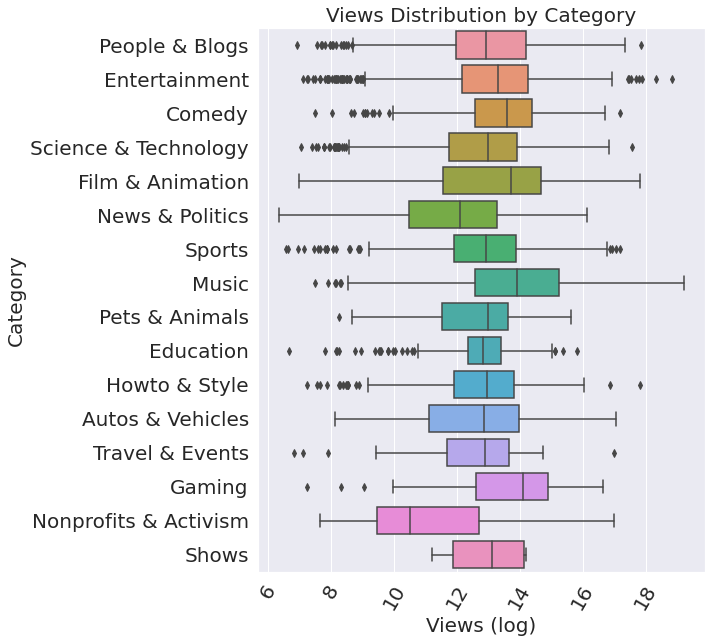

In [79]:
plt.figure(figsize=(8,10))
ax = sns.boxplot(y="category", x="views_log", data=data_clean)

plt.xlabel('Views (log)', fontsize=20)
plt.ylabel('Category', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(rotation=60, fontsize=20)
plt.title('Views Distribution by Category', fontsize=20)
plt.show()

In [80]:
data_clean[data_clean['views'] < 518107].shape[0] / data_clean.shape[0] * 100

49.9921272240592

In [81]:
data_clean['views'].quantile(q=0.80)

1888088.0

* **92.89%** of trending videos have less than 5 million views

* Videos with **largest number of views is Childish Gambino 'This Is America' Music Video, with 225 Million Views**

* **Gaming is the category with the highest average number of likes, followed by Music** 

## Relationship

In [82]:
data_clean.columns

Index(['video_id', 'trending_date', 'title', 'channel_title', 'category_id',
       'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count',
       'comments_disabled', 'ratings_disabled', 'video_error_or_removed',
       'description', 'id', 'category', 'likes_log', 'views_log',
       'dislikes_log', 'comment_log'],
      dtype='object')

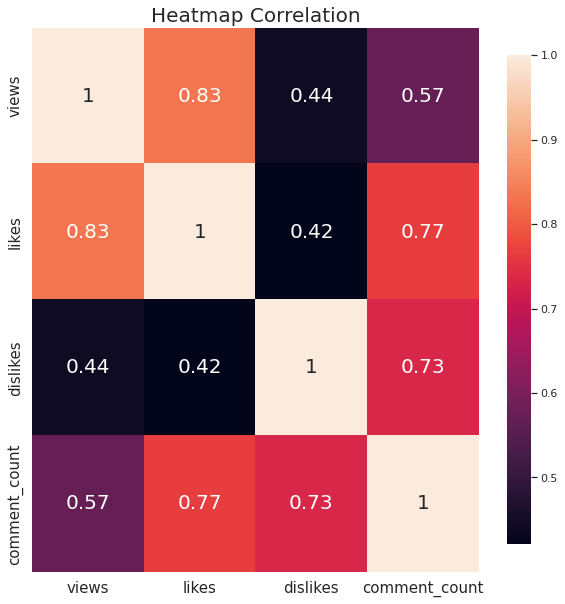

In [83]:
plt.figure(figsize=(10,10))

sns.heatmap(data_clean[['views', 'likes', 'dislikes', 'comment_count']].corr(), annot = True, annot_kws={'fontsize':20}, cbar_kws={"shrink": 0.9})
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Heatmap Correlation', fontsize=20)
plt.show()

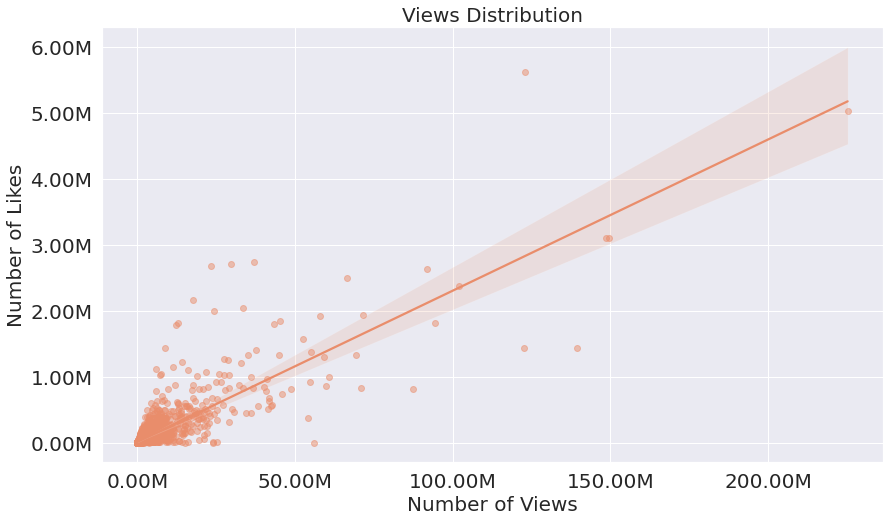

In [84]:
plt.figure(figsize=(14,8))
ax = sns.regplot(data = data_clean, x='views', y='likes', scatter_kws={'alpha':0.5})
# plt.figure(figsize=(14,8))
# plt.plot(data_clean['views'], data_clean['likes'], 'o',markersize=10, alpha=0.2)
# plt.axis([0,0.2e8,0,0.6e6])
# plt.xlabel('Num of Views')
# plt.ylabel('Num of Likes')
formatter = ticker.FuncFormatter(func=lambda x,y: '{:.2f}M'.format(x/1e6))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))

plt.xlabel('Number of Views', fontsize=20)
plt.ylabel('Number of Likes', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Views Distribution', fontsize=20)
plt.show()

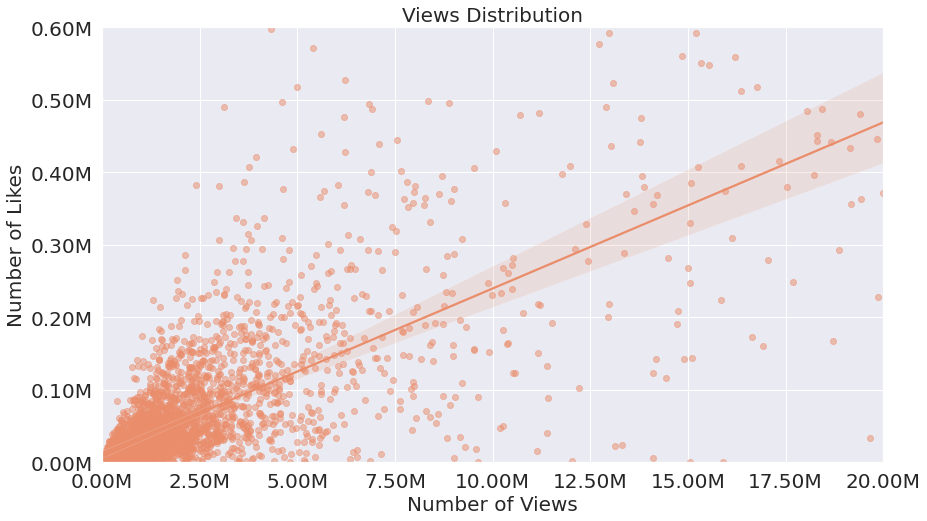

In [85]:
plt.figure(figsize=(14,8))
ax = sns.regplot(data = data_clean, x='views', y='likes', scatter_kws={'alpha':0.5})
# plt.figure(figsize=(14,8))
# plt.plot(data_clean['views'], data_clean['likes'], 'o',markersize=10, alpha=0.2)
plt.axis([0,0.2e8,0,0.6e6])
# plt.xlabel('Num of Views')
# plt.ylabel('Num of Likes')
formatter = ticker.FuncFormatter(func=lambda x,y: '{:.2f}M'.format(x/1e6))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(formatter))

plt.xlabel('Number of Views', fontsize=20)
plt.ylabel('Number of Likes', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Views Distribution', fontsize=20)
plt.show()


* based on the heatmap, **all correlations from numerical data are positive**, **Likes and views** have the largest correlation value of **0.84.**

## Datetime Data


### Number of days between trending and upload



In [86]:
# Drop duplicated data and keep first occurence
data_first = data.drop_duplicates(subset ="video_id", keep='first')
data_first['upload_to_trending'] = (data_first['trending_date'].dt.date - data_first['publish_time'].dt.date).dt.days
data_first

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


video_id trending_date  \
0      2kyS6SvSYSE    2017-11-14   
1      0mlNzVSJrT0    2017-11-14   
2      STI2fI7sKMo    2017-11-14   
3      KODzih-pYlU    2017-11-14   
4      8mhTWqWlQzU    2017-11-14   
...            ...           ...   
40883  pwGbwYAfSmg    2018-05-27   
40892  lM0yu7c6lQk    2017-12-23   
40903  Q1CFfU2gXHw    2018-01-26   
40908  7_FJUSBFbJM    2018-04-14   
40924  V6ElE2xs48c    2018-05-12   

                                                   title       channel_title  \
0                     WE WANT TO TALK ABOUT OUR MARRIAGE        CaseyNeistat   
1                                   Me-O Cats Commercial             Nobrand   
2      AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...  Shawn Johnson East   
3      BLIND(folded) CAKE DECORATING CONTEST (with Mo...        Grace Helbig   
4          Wearing Online Dollar Store Makeup For A Week      Safiya Nygaard   
...                                                  ...                 ...   
40883                  5 books worth reading this summer          Bill Gates   
40892  You're not crazy. Apple is slowing down older ...                CNET   
40903  Apple HomePod: Everything to know before you b...                CNET   
40908  Game of Zones - Game of Zones - S5:E1: 'A Gold...     Bleacher Report   
40924       Game of Zones - S5:E5: The Isle of Van Gundy     Bleacher Report   

       category_id              publish_time  \
0               22 2017-11-13 17:13:01+00:00   
1               22 2017-04-21 06:47:32+00:00   
2               22 2017-11-11 15:00:03+00:00   
3               22 2017-11-11 18:08:04+00:00   
4               22 2017-11-11 01:19:33+00:00   
...            ...                       ...   
40883           29 2018-05-21 13:30:33+00:00   
40892           43 2017-12-22 01:16:16+00:00   
40903           43 2018-01-24 20:08:16+00:00   
40908           43 2018-04-12 21:00:12+00:00   
40924           43 2018-05-10 21:01:22+00:00   

                                                    tags    views   likes  \
0                                        SHANtell martin   748374   57527   
1                              cute|"cats"|"thai"|"eggs"    98966    2486   
2      shawn johnson|"andrew east"|"shawn east"|"shaw...   321053    4451   
3      itsgrace|"funny"|"comedy"|"vlog"|"grace"|"helb...   197062    7250   
4      wearing online dollar store makeup for a week|...  2744430  115426   
...                                                  ...      ...     ...   
40883                                       Bill|"Gates"   250175    8455   
40892  Apple|"iPhone Slowdown"|"Apple Battery"|"Cultu...   110112    3547   
40903  Apple|"Homepod"|"smart home"|"Google Home"|"Am...    36609     810   
40908  bleacher report|"br"|"nba"|"game of zones"|"go...   657183   24107   
40924  bleacher report|"br"|"nba"|"Stan Van Gundy"|"J...   765531   18681   

       dislikes  comment_count  comments_disabled  ratings_disabled  \
0          2966          15954              False             False   
1           184            532              False             False   
2          1772            895              False             False   
3           217            456              False             False   
4          1110           6541              False             False   
...         ...            ...                ...               ...   
40883       126            552              False             False   
40892       180           1426              False             False   
40903        66            220              False             False   
40908       310           1825              False             False   
40924       461           1444              False             False   

       video_error_or_removed  \
0                       False   
1                       False   
2                       False   
3                       False   
4                       False   
...                       ...   
40883                   False 

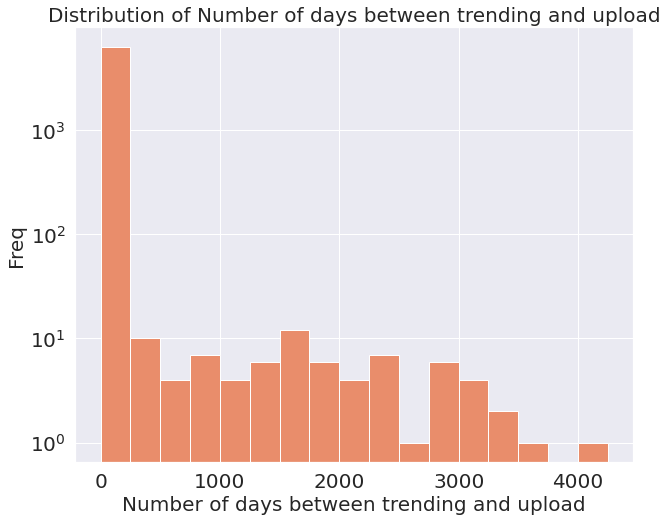

In [87]:
plt.figure(figsize=(10,8))
data_first['upload_to_trending'].plot(kind='hist', bins=np.arange(0, 4500, 250), logy=True)
plt.xlabel('Number of days between trending and upload', fontsize=20)
plt.ylabel('Freq', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Distribution of Number of days between trending and upload', fontsize=20)
plt.show()

In [88]:
data_first['upload_to_trending'].describe().to_frame()

upload_to_trending
count         6351.000000
mean            22.522280
std            209.963296
min              0.000000
25%              1.000000
50%              2.000000
75%              3.000000
max           4215.000000

In [89]:
data_first[data_first['upload_to_trending'] < 3].shape[0] / data_first.shape[0] * 100

73.51598173515981

In [90]:
data_first[data_first['upload_to_trending'] == 0].shape[0] / data_first.shape[0] * 100

1.8894662257912138

In [91]:
data_first[data_first['upload_to_trending'] > 3000].shape[0] / data_first.shape[0] * 100

0.1259644150527476

In [92]:
data_first.sort_values('upload_to_trending', ascending=False).head()

video_id trending_date  \
7054   MJO3FmmFuh4    2018-02-05   
19639  UQtt9I6c-YM    2018-01-06   
26483  wFEAoF7RC7Y    2017-11-25   
26522  Y8JGfi4MJ8k    2017-11-26   
19087  rO_mAQC9bv0    2017-11-19   

                                                   title      channel_title  \
7054                    Budweiser - Original Whazzup? ad            dannotv   
19639                        Kramer vs Kramer-Clou Scene  Livia Giustiniani   
26483                   Behind The Sounds: That's Not Me    BehindTheSounds   
26522                   SAOIRSE RONAN - MORONIC (IRONIC)         flirppy242   
19087  Amazon.com commercial Xmas 1999Magnetic Whale Art       astroboy1960   

       category_id              publish_time  \
7054            24 2006-07-23 08:24:11+00:00   
19639            1 2008-04-05 18:22:40+00:00   
26483           10 2008-06-17 00:07:56+00:00   
26522           10 2008-08-07 12:16:58+00:00   
19087            1 2009-03-10 00:27:20+00:00   

                                                    tags   views  likes  \
7054                      Budweiser|"Bud"|"Whazzup"|"ad"  258506    459   
19639  Meryl|"Streep"|"kramer"|"vs"|"dustin"|"hoffman...   49942     46   
26483  Beach|"Boys"|"Brian"|"Wilson"|"Dennis"|"Carl"|...   86744    469   
26522  SAOIRSE|"RONAN"|"MORONIC"|"IRONIC"|"IZZIE"|"CO...   26482     78   
19087  amazon|"commerical"|"y2k"|"sing"|"along"|"mitc...   15382     33   

       dislikes  comment_count  comments_disabled  ratings_disabled  \
7054        152             82              False             False   
19639         6             26              False             False   
26483         4            105              False             False   
26522         1              7              False             False   
19087         1             10              False             False   

       video_error_or_removed  \
7054                    False   
19639                   False   
26483                   False   
26522                   False   
19087                   False   

                                             description  id  \
7054   Original Whazzup ad - however, there is a litt...  24   
19639               Poor Meryl...she was really scaredxD   1   
26483  A video detailing the creative process behind ...  10   
26522   EL NOVIO DE MI MADRE\r\nI COULD NEVER BE A WOMAN  10   
19087  IMHO the best of Amazon's Christmas 1999 ads. ...   1   

               category  upload_to_trending  
7054      Entertainment                4215  
19639  Film & Animation                3563  
26483             Music                3448  
26522             Music                3398  
19087  Film & Animation                3176

* **73.51%** of videos become trending in less than 3 days

* only **1.88%** of videos are trending on the same day as when they were uploaded

* **largest Number of days between trending and upload is 4125 days or about 11 years**, the video is titled 'Budweiser - Original Whazzup? ad' uploaded by dannotv

### How long those videos trending

In [93]:
trending_days = data['video_id'].value_counts().to_frame().reset_index()
trending_days.rename(columns={"index":'video_id','video_id':'trending_days'}, inplace=True)

In [94]:
data_merge = pd.merge(data_first, trending_days, on='video_id')

In [95]:
data_merge['trending_days'].describe().to_frame()

trending_days
count    6351.000000
mean        6.447646
std         4.642806
min         1.000000
25%         3.000000
50%         6.000000
75%         8.000000
max        30.000000

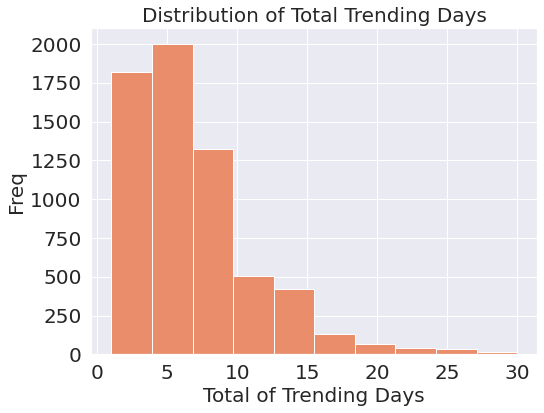

In [96]:
plt.figure(figsize=(8,6))
data_merge['trending_days'].plot(kind='hist')
plt.xlabel('Total of Trending Days', fontsize=20)
plt.ylabel('Freq', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('Distribution of Total Trending Days', fontsize=20)
plt.show()

### Consecutive Trending Days

In [97]:
data_sorted = data[['video_id', 'trending_date']].sort_values(['video_id', 'trending_date'])
s = data_sorted.groupby('video_id').trending_date.diff().dt.days.ne(1).cumsum()
s
data_sorted = data_sorted.groupby(['video_id', s]).size().reset_index(level=1, drop=True)

In [98]:
data_sorted = data_sorted.reset_index()
data_sorted.rename(columns={0:'consecutive_trending_days'}, inplace=True)
data_sorted

video_id  consecutive_trending_days
0     -0CMnp02rNY                          6
1     -0NYY8cqdiQ                          1
2     -1Hm41N0dUs                          3
3     -1yT-K3c6YI                          4
4     -2RVw2_QyxQ                          3
...           ...                        ...
6954  zxUwbflE1SY                          5
6955  zxwfDlhJIpw                         13
6956  zxwfDlhJIpw                         10
6957  zy0b9e40tK8                          1
6958  zzQsGL_F9_c                          2

[6959 rows x 2 columns]

In [99]:
data_sorted.sort_values('consecutive_trending_days', ascending=False)

video_id  consecutive_trending_days
6257  t4pRQ0jn23Q                         28
811   6S9c5nnDd_s                         28
2978  QBL8IRJ5yHU                         28
2526  MAjY8mCTXWk                         28
5987  r-3iathMo7o                         28
...           ...                        ...
6030  rL4WkebTT_U                          1
6029  rJfFxDQ-8ok                          1
3065  R9s5_Ji33xY                          1
3070  RBpLVXNN6i0                          1
3479  V1Pl8CzNzCw                          1

[6959 rows x 2 columns]

In [100]:
data_cons = pd.merge(data_first, data_sorted, on='video_id')

In [101]:
data_cons['consecutive_trending_days'].describe().to_frame()

consecutive_trending_days
count                6959.000000
mean                    5.884322
std                     4.367000
min                     1.000000
25%                     3.000000
50%                     5.000000
75%                     8.000000
max                    28.000000

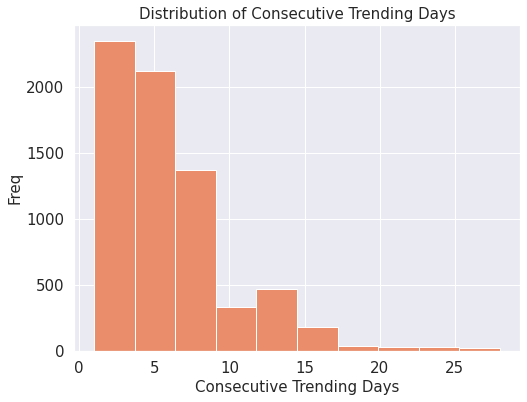

In [102]:
plt.figure(figsize=(8,6))
data_cons['consecutive_trending_days'].plot(kind='hist')
plt.xlabel('Consecutive Trending Days', fontsize=15)
plt.ylabel('Freq', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Distribution of Consecutive Trending Days', fontsize=15)
plt.show()

In [103]:
data_cons.sort_values('consecutive_trending_days', ascending=False).head(10)

video_id trending_date  \
6642  QBL8IRJ5yHU    2018-05-15   
3332  r-3iathMo7o    2018-05-15   
2183  t4pRQ0jn23Q    2018-05-15   
2175  j4KvrAUjn6c    2018-05-14   
3670  6S9c5nnDd_s    2018-05-16   
3669  NBSAQenU2Bk    2018-05-15   
5556  MAjY8mCTXWk    2018-05-15   
5565  H7gh2fmdjCU    2018-05-18   
2894  1purAy2MsOc    2018-05-16   
5564  6SuMbFuKDf8    2018-05-18   

                                                  title       channel_title  \
6642  Why I'm So Scared (being myself and crying too...       grav3yardgirl   
3332               The ULTIMATE $30,000 Gaming PC Setup       Unbox Therapy   
2183  YoungBoy Never Broke Again Goes Sneaker Shoppi...             Complex   
2175         WE MADE OUR MOM CRY...HER DREAM CAME TRUE!    Lucas and Marcus   
3670  Bohemian Rhapsody | Teaser Trailer [HD] | 20th...    20th Century Fox   
3669  Rooster Teeth Animated Adventures - Millie So ...       Rooster Teeth   
5556  周杰倫 Jay Chou【不愛我就拉倒 If You Don't Love Me, It's...     杰威爾音樂 JVR Music   
5565                     Calum Scott - What I Miss Most      CalumScottVEVO   
2894                         22 Years of Life Milestone         TheOdd2sOut   
5564  Backstreet Boys - Don't Go Breaking My Heart (...  BackstreetBoysVEVO   

      category_id              publish_time  \
6642           26 2018-05-14 19:00:01+00:00   
3332           28 2018-05-13 19:00:25+00:00   
2183           24 2018-05-14 14:00:03+00:00   
2175           24 2018-05-13 18:03:56+00:00   
3670            1 2018-05-15 13:01:12+00:00   
3669            1 2018-05-14 13:00:01+00:00   
5556           10 2018-05-14 15:59:47+00:00   
5565           10 2018-05-16 23:00:00+00:00   
2894           23 2018-05-14 19:36:05+00:00   
5564           10 2018-05-17 04:00:01+00:00   

                                                   tags    views   likes  \
6642  beauty|"how to"|"makeup"|"howto"|"style"|"fash...  1469627  188652   
3332  gaming setup|"gaming"|"setup"|"fortnite"|"fort...  4700460  103430   
2183  sneakerhead|"complex"|"complex originals"|"sne...  1199587   49709   
2175  Lucas and Marcus|"Marcus and Lucas"|"Dobre"|"D...  2131702   54280   
3670  Trailer|"bohemian rhapsody"|"queen"|"freddie m...  4215671  161058   
3669  Rooster Teeth|"RT"|"animation"|"television"|"f...   404162   17920   
5556  周杰倫|"Jay"|"Chou"|"周董"|"周杰伦"|"周傑倫"|"杰威尔"|"周周"|"...   916128   40485   
5565  Calum|"Scott"|"What"|"Miss"|"Most"|"Capitol"|"...   664458   45750   
2894   Birthday|"rice"|"cake"|"one million"|"Milestone"   688645   73735   
5564  Backstreet Boys|"Don't Go Breaking My Heart"|"...  2822391  131909   

      dislikes  comment_count  comments_disabled  ratings_disabled  \
6642      3124          33032              False             False   
3332      8028          13293              False             False   
2183      2380           7261              False             False   
2175      4696          10705              False             False   
3670      2198          10289              False             False   
3669        79            642              False             False   
5556      1042           4746              False             False   
5565       289           2354              False             False   
2894       466          23002              False             False   
5564      5164          16487              False             False   

      video_error_or_removed  \
6642                   False   
3332                   False   
2183                   False   
2175                   False   
3670                   False   
3669                   False   
5556                   False   
5565                   False   
2894                   False   
5564                   False   

                                            description  id  \
6642  I will never be able to say Thank You enough.....  26   
3332  Fortnite, PUBG, Far Cry 5? Which game would yo...  28   
2183  YoungBoy Never Broke Again goes Sneaker Shoppi...  24   
2175  BEST MOM EVER! T

* 

### Number of Videos Trending based on Month of trending date

In [104]:
data['trending_month'] = data.trending_date.dt.month

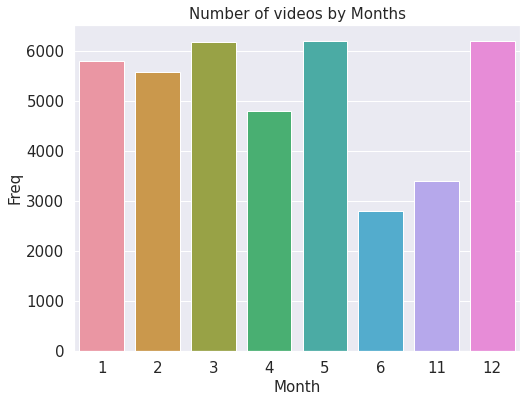

In [105]:
plt.figure(figsize=(8,6))
sns.countplot(data = data, x = 'trending_month')
plt.xlabel('Month', fontsize=15)
plt.ylabel('Freq', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Number of videos by Months', fontsize=15)
plt.show()

In [106]:
print(data['trending_date'].min())
print(data['trending_date'].max())

2017-11-14 00:00:00
2018-06-14 00:00:00


In [107]:
data['publish_month'] = data.publish_time.dt.month

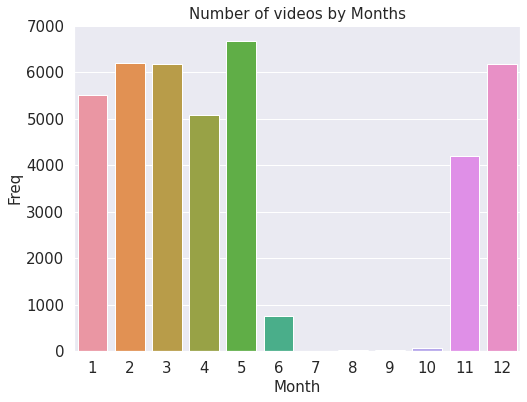

In [108]:
plt.figure(figsize=(8,6))
sns.countplot(data = data, x = 'publish_month')
plt.xlabel('Month', fontsize=15)
plt.ylabel('Freq', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Number of videos by Months', fontsize=15)
plt.show()

# Segmentation

## Topic Modeling on Title

In [109]:
nltk.download('averaged_perceptron_tagger')
df_title['pos_tags'] = df_title['title_tokenized'].apply(nltk.tag.pos_tag)

nltk.download('wordnet')
nltk.download('omw-1.4')
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
df_title['wordnet_pos'] = df_title['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
df_title['lemmatized'] = df_title['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df_title['lemma_str'] = [' '.join(map(str,l)) for l in df_title['lemmatized']]
df_title.head()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


title_cleaned  \
0                                 want talk marriage   
1                                meo cats commercial   
2  affairs ex boyfriends 18million net worth goog...   
3  blindfolded cake decorating contest molly burk...   
4            wearing online dollar store makeup week   

                                     title_tokenized  \
0                             [want, talk, marriage]   
1                            [meo, cats, commercial]   
2  [affairs, ex, boyfriends, 18million, net, wort...   
3  [blindfolded, cake, decorating, contest, molly...   
4     [wearing, online, dollar, store, makeup, week]   

                                            pos_tags  \
0           [(want, JJ), (talk, NN), (marriage, NN)]   
1         [(meo, NN), (cats, NNS), (commercial, JJ)]   
2  [(affairs, NNS), (ex, VBD), (boyfriends, NNS),...   
3  [(blindfolded, VBN), (cake, NN), (decorating, ...   
4  [(wearing, VBG), (online, JJ), (dollar, NN), (...   

                                         wordnet_pos  \
0              [(want, a), (talk, n), (marriage, n)]   
1             [(meo, n), (cats, n), (commercial, a)]   
2  [(affairs, n), (ex, v), (boyfriends, n), (18mi...   
3  [(blindfolded, v), (cake, n), (decorating, v),...   
4  [(wearing, v), (online, a), (dollar, n), (stor...   

                                          lemmatized  \
0                             [want, talk, marriage]   
1                             [meo, cat, commercial]   
2  [affair, ex, boyfriend, 18million, net, worth,...   
3  [blindfold, cake, decorate, contest, molly, bu...   
4        [wear, online, dollar, store, makeup, week]   

                                           lemma_str  
0                                 want talk marriage  
1                                 meo cat commercial  
2  affair ex boyfriend 18million net worth google...  
3  blindfold cake decorate contest molly burke gr...  
4               wear online dollar store makeup week

In [110]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df_title['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


10  2017  2018  ad  adam  american  announcement  answer  apple  audio  \
0      0     0     0   0     0         0             0       0      0      0   
1      0     0     0   0     0         0             0       0      0      0   
2      0     0     0   0     0         0             0       0      0      0   
3      0     0     0   0     0         0             0       0      0      0   
4      0     0     0   0     0         0             0       0      0      0   
...   ..   ...   ...  ..   ...       ...           ...     ...    ...    ...   
6346   0     0     0   0     0         0             0       0      0      0   
6347   0     0     0   0     0         0             0       0      2      0   
6348   0     0     0   0     0         0             0       0      2      0   
6349   0     0     0   0     0         0             0       0      0      0   
6350   0     0     0   0     0         0             0       0      0      0   

      ...  weird  white  wild  win  wire  woman  work  world  year  youtube  
0     ...      0      0     0    0     0      0     0      0     0        0  
1     ...      0      0     0    0     0      0     0      0     0        0  
2     ...      0      0     0    0     0      0     0      0     0        0  
3     ...      0      0     0    0     0      0     0      0     0        0  
4     ...      0      0     0    0     0      0     0      0     0        0  
...   ...    ...    ...   ...  ...   ...    ...   ...    ...   ...      ...  
6346  ...      0      0     0    0     0      0     0      0     0        0  
6347  ...      0      0     0    0     0      0     0      0     0        0  
6348  ...      0      0     0    0     0      0     0      0     0        0  
6349  ...      0      0     0    0     0      0     0      0     0        0  
6350  ...      0      0     0    0     0      0     0      0     0        0  

[6351 rows x 225 columns]

In [111]:
lda_model = LatentDirichletAllocation(n_components=30, learning_method='online', max_iter=20, random_state=0).fit(tf)
no_top_words = 10
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx), end=' ')
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0: new movie 10 year bad team old star man find
Topic 1: go christmas every day first new time year ever never
Topic 2: game black play man come say woman golden panther hair
Topic 3: world test big perfect minute bbc film fall first christmas
Topic 4: video official ft try lyric music part explain tutorial family
Topic 5: star war top house nfl tour episode apple miss avenger
Topic 6: make best diy food battle interview work kevin cut stop
Topic 7: react use song mv iphone google hot make bts live
Topic 8: 2017 full know youtube great tb face like react use
Topic 9: get makeup week name friend car ad bts star perfect
Topic 10: live news watch stephen smith call president moment harry bowl
Topic 11: look night inside red dead high film lip first bbc
Topic 12: like scene secret people behind hit final show get refinery29
Topic 13: take last kid jedi school dance camila secret show star
Topic 14: love cake baby hot kim announcement grace name vs know
Topic 15: voice fire date justi

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

In [ ]:
lda_topic_values = lda_model.transform(tf)
data_first['lda_title'] = lda_topic_values.argmax(axis=1)

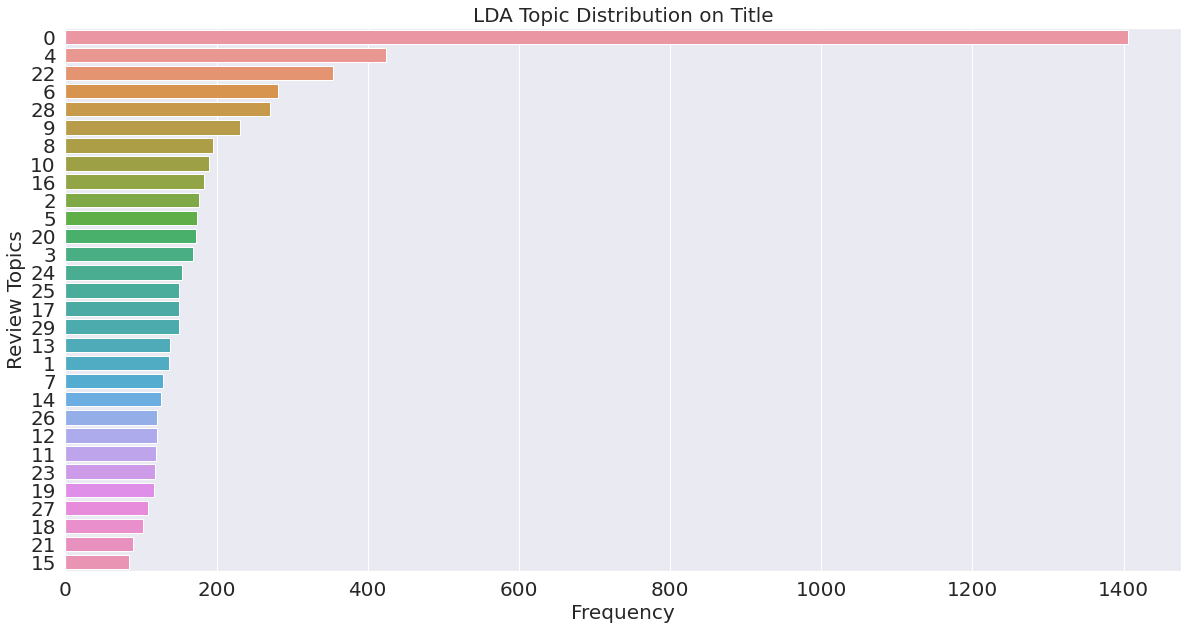

In [114]:
cnt_lda_title = data_first['lda_title'].value_counts().to_frame().reset_index()
cnt_lda_title.rename(columns = {'index':'Topic', 'lda_title':'Freq'}, inplace=True)
cnt_lda_title.Topic = cnt_lda_title.Topic.astype('str')
plt.figure(figsize=(20,10))
sns.barplot(data = cnt_lda_title.sort_values('Freq', ascending = False), x = 'Freq', y = 'Topic')
plt.title("LDA Topic Distribution on Title", fontsize=20)
plt.ylabel('Review Topics', fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)

## Topic Modeling on Tags

In [115]:
df_tags['pos_tags'] = df_tags['tags_tokenized'].apply(nltk.tag.pos_tag)

df_tags['wordnet_pos'] = df_tags['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()
df_tags['lemmatized'] = df_tags['wordnet_pos'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

df_tags['lemma_str'] = [' '.join(map(str,l)) for l in df_tags['lemmatized']]
df_tags.head()

tags_cleaned  \
0                                    shantell martin   
1                                cute cats thai eggs   
2  shawn johnson andrew east shawn east shawn and...   
3  itsgrace funny comedy vlog grace helbig graceh...   
4  wearing online dollar store makeup week online...   

                                      tags_tokenized  \
0                                 [shantell, martin]   
1                           [cute, cats, thai, eggs]   
2  [shawn, johnson, andrew, east, shawn, east, sh...   
3  [itsgrace, funny, comedy, vlog, grace, helbig,...   
4  [wearing, online, dollar, store, makeup, week,...   

                                            pos_tags  \
0                     [(shantell, NN), (martin, NN)]   
1  [(cute, NN), (cats, NNS), (thai, VBP), (eggs, ...   
2  [(shawn, NN), (johnson, NN), (andrew, VBD), (e...   
3  [(itsgrace, NN), (funny, JJ), (comedy, NN), (v...   
4  [(wearing, VBG), (online, JJ), (dollar, NN), (...   

                                         wordnet_pos  \
0                       [(shantell, n), (martin, n)]   
1       [(cute, n), (cats, n), (thai, v), (eggs, n)]   
2  [(shawn, n), (johnson, n), (andrew, v), (east,...   
3  [(itsgrace, n), (funny, a), (comedy, n), (vlog...   
4  [(wearing, v), (online, a), (dollar, n), (stor...   

                                          lemmatized  \
0                                 [shantell, martin]   
1                             [cute, cat, thai, egg]   
2  [shawn, johnson, andrew, east, shawn, east, sh...   
3  [itsgrace, funny, comedy, vlog, grace, helbig,...   
4  [wear, online, dollar, store, makeup, week, on...   

                                           lemma_str  
0                                    shantell martin  
1                                  cute cat thai egg  
2  shawn johnson andrew east shawn east shawn and...  
3  itsgrace funny comedy vlog grace helbig graceh...  
4  wear online dollar store makeup week online do...

In [116]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(df_tags['lemma_str'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


08282016ntflxuscan  10  100  12  13  15  16  2017  2018  29  ...  \
0                      0   0    0   0   0   0   0     0     0   0  ...   
1                      0   0    0   0   0   0   0     0     0   0  ...   
2                      0   0    0   0   0   0   0     0     0   0  ...   
3                      0   0    0   0   0   0   0     0     0   0  ...   
4                      0   0    0   0   0   0   0     0     0   0  ...   
...                  ...  ..  ...  ..  ..  ..  ..   ...   ...  ..  ...   
6346                   0   0    0   0   0   0   0     0     0   0  ...   
6347                   0   0    0   0   0   0   0     0     0   0  ...   
6348                   0   0    0   0   0   0   0     0     0   0  ...   
6349                   0   0    0   0   0   0   0     0     0   0  ...   
6350                   0   0    0   0   0   0   0     0     0   0  ...   

      youtube  youtuber  youtubers  مصارعه  कशत  डबल  पहलवन  मच  वयवसयक  \
0           0         0          0       0    0    0      0   0       0   
1           0         0          0       0    0    0      0   0       0   
2           0         2          0       0    0    0      0   0       0   
3           0         0          0       0    0    0      0   0       0   
4           0         0          0       0    0    0      0   0       0   
...       ...       ...        ...     ...  ...  ...    ...  ..     ...   
6346        0         0          0       0    0    0      0   0       0   
6347        0         0          0       0    0    0      0   0       0   
6348        0         0          0       0    0    0      0   0       0   
6349        0         0          0       0    0    0      0   0       0   
6350        0         0          0       0    0    0      0   0       0   

      सपरसटर  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
6346       0  
6347       0  
6348       0  
6349       0  
6350       0  

[6351 rows x 1012 columns]

In [117]:
lda_model = LatentDirichletAllocation(n_components=30, learning_method='online', max_iter=20, random_state=0).fit(tf)
no_top_words = 10
              
display_topics(lda_model, tf_feature_names, no_top_words)

Topic 0: school high hack ever standup honest learn blue tesla amaze
Topic 1: animal take big king jack documentary great wild fry jr
Topic 2: espn perfect go charlie health bbc nick ted heart way
Topic 3: challenge react kid google liza reaction nfl brother fine know
Topic 4: make diy disney fox year box nintendo homemade world hannah
Topic 5: news smith nba trump basketball game animation live lebron break
Topic 6: interview sport celebrity none football entertainment game tonight magazine soccer
Topic 7: tv television car netflix series original john watch movie online
Topic 8: test voice buzzfeed food team try people taste best eat
Topic 9: 2017 live christmas award red 2018 holiday seth best meyers
Topic 10: makeup tutorial beauty black get hair face pet random video
Topic 11: family girl noggin funny anthony friendly fun boy robot lol
Topic 12: food recipe cook cake water kitchen hot bake world chef
Topic 13: star war last jedi bts cardi mark scene johnson explain
Topic 14: super

In [118]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
26     119.070190   64.655502       1        1  7.222425
5       54.382130  109.799164       2        1  5.899486
10    -161.423965 -103.744957       3        1  5.028341
16    -135.370758   36.673065       4        1  5.003357
27     177.317215  -66.872452       5        1  4.390500
7      -16.436356  142.453796       6        1  4.331813
24      31.052383  204.777573       7        1  3.691420
9      -25.024384 -186.083466       8        1  3.575696
3      -68.157486   20.934038       9        1  3.526200
15      -3.751695    4.961509      10        1  3.496076
12    -114.470009 -179.605469      11        1  3.401446
23    -110.729126  -40.476776      12        1  3.387154
17      42.552418  -42.789406      13        1  3.227385
22     -10.661536   71.922211      14        1  3.113946
1      112.652969  -16.279951      15        1  3.049322
6     -195.499146  -25.853945      16        1  2.934680
29    -207.165924   66.070419      17        1  2.851661
13      10.217649 -110.752060      18        1  2.850208
25     -81.255081   96.477776      19        1  2.831534
21     -77.253441  192.755219      20        1  2.746651
8      182.353027  110.412880      21        1  2.738370
4       89.766510  -93.997673      22        1  2.698907
11     -36.483528  -52.542774      23        1  2.607856
18     -72.052170 -112.144821      24        1  2.400685
28     144.822769 -150.811508      25        1  2.358339
0     -148.475357  135.678162      26        1  2.268766
19     189.811615   17.382956      27        1  2.244955
20      56.555355   33.755768      28        1  2.107006
2       58.988537 -178.376541      29        1  2.031947
14     110.556717  164.236694      30        1  1.983870, topic_info=           Term         Freq        Total Category  logprob  loglift
941       video  1736.000000  1736.000000  Default  30.0000  30.0000
563      makeup  1004.000000  1004.000000  Default  29.0000  29.0000
800        show  1425.000000  1425.000000  Default  28.0000  28.0000
629        news  1080.000000  1080.000000  Default  27.0000  27.0000
610       music   814.000000   814.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
991       world     8.132979   433.444128  Topic30  -5.6464  -0.0557
455  jacksfilms     0.033260    23.545394  Topic30 -11.1458  -2.6422
514         lag     0.033260    24.580218  Topic30 -11.1458  -2.6852
362       giant     0.033458   111.219819  Topic30 -11.1398  -4.1888
235     dessert     0.033370    59.450604  Topic30 -11.1425  -3.5651

[1097 rows x 6 columns], token_table=      Topic      Freq                Term
term                                     
0         6  0.973307  08282016ntflxuscan
1         7  0.996456                  10
2        21  0.553192                 100
2        22  0.430260                 100
3         8  0.848202                  12
...     ...       ...                 ...
1004      9  0.873856           youtubers
1004     23  0.109232           youtubers
1006     17  0.989679                 कशत
1007     17  0.989679                 डबल
1009     17  0.976222                  मच

[1360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[27, 6, 11, 17, 28, 8, 25, 10, 4, 16, 13, 24, 18, 23, 2, 7, 30, 14, 26, 22, 9, 5, 12, 19, 29, 1, 20, 21, 3, 15])

In [119]:
lda_topic_values = lda_model.transform(tf)
data_first['lda_tags'] = lda_topic_values.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [120]:
cnt_lda_tags = data_first['lda_tags'].value_counts().to_frame().reset_index()
cnt_lda_tags.rename(columns = {'index':'Topic', 'lda_tags':'Freq'}, inplace=True)
cnt_lda_tags.Topic = cnt_lda_tags.Topic.astype('str')
plt.figure(figsize=(20,10))
sns.barplot(data = cnt_lda_tags.sort_values('Freq', ascending = False), x = 'Freq', y = 'Topic')
plt.title("LDA Topic Distribution on Tags", fontsize=20)
plt.ylabel('Review Topics', fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=20)

(array([  0., 100., 200., 300., 400., 500., 600.]),
 <a list of 7 Text major ticklabel objects>)

In [121]:
data_first.head()

video_id trending_date  \
0  2kyS6SvSYSE    2017-11-14   
1  0mlNzVSJrT0    2017-11-14   
2  STI2fI7sKMo    2017-11-14   
3  KODzih-pYlU    2017-11-14   
4  8mhTWqWlQzU    2017-11-14   

                                               title       channel_title  \
0                 WE WANT TO TALK ABOUT OUR MARRIAGE        CaseyNeistat   
1                               Me-O Cats Commercial             Nobrand   
2  AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...  Shawn Johnson East   
3  BLIND(folded) CAKE DECORATING CONTEST (with Mo...        Grace Helbig   
4      Wearing Online Dollar Store Makeup For A Week      Safiya Nygaard   

   category_id              publish_time  \
0           22 2017-11-13 17:13:01+00:00   
1           22 2017-04-21 06:47:32+00:00   
2           22 2017-11-11 15:00:03+00:00   
3           22 2017-11-11 18:08:04+00:00   
4           22 2017-11-11 01:19:33+00:00   

                                                tags    views   likes  \
0                                    SHANtell martin   748374   57527   
1                          cute|"cats"|"thai"|"eggs"    98966    2486   
2  shawn johnson|"andrew east"|"shawn east"|"shaw...   321053    4451   
3  itsgrace|"funny"|"comedy"|"vlog"|"grace"|"helb...   197062    7250   
4  wearing online dollar store makeup for a week|...  2744430  115426   

   dislikes  comment_count  comments_disabled  ratings_disabled  \
0      2966          15954              False             False   
1       184            532              False             False   
2      1772            895              False             False   
3       217            456              False             False   
4      1110           6541              False             False   

   video_error_or_removed                                        description  \
0                   False  SHANTELL'S CHANNEL - https://www.youtube.com/s...   
1                   False  Kittens come out of the eggs in a Thai commerc...   
2                   False  Subscribe for weekly videos ▶ http://bit.ly/sj...   
3                   False  Molly is an god damn amazing human and she cha...   
4                   False  I found this online dollar store called ShopMi...   

   id        category  upload_to_trending  lda_title  lda_tags  
0  22  People & Blogs                   1         22        20  
1  22  People & Blogs                 207         26        18  
2  22  People & Blogs                   3          7         3  
3  22  People & Blogs                   3         14        17  
4  22  People & Blogs                   3          9        10

In [122]:
# %%shell
# jupyter nbconvert --to html //Your notebook path file.ipynb